In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as sp_dist
import os
import pickle

# Lectura de archivos

In [2]:
def getPathfiles(string_path):
    list_files = os.listdir(string_path)
    
    list_pathfiles = []
    for i in list_files:
        filepath = string_path+'/'+i
        list_pathfiles.append(filepath)
    
    dictionary = dict()
    
    for i in range(len(list_files)):
        dictionary[list_files[i]] = list_pathfiles[i]
    
    return dictionary

def getImagesFromPathfile(list_pathfile,mode=cv2.COLOR_BGR2RGB):
    list_imgs = []
    for i in range(len(list_pathfile)):
        img = cv2.imread(list_pathfile[i])
        img = cv2.cvtColor(img, mode)
        list_imgs.append(img)
        
    return list_imgs

In [8]:
dict_folder = getPathfiles('PIByB_3')

print(dict_folder)

imgs_folder_rgb = getImagesFromPathfile([*dict_folder.values()],mode=cv2.COLOR_BGR2RGB)
imgs_folder_yuv = getImagesFromPathfile([*dict_folder.values()],mode=cv2.COLOR_BGR2YUV)
imgs_folder_hsv = getImagesFromPathfile([*dict_folder.values()],mode=cv2.COLOR_BGR2HSV)

{'image-1.tif': 'PIByB_3/image-1.tif', 'Image-2.tif': 'PIByB_3/Image-2.tif', 'Image-3.tif': 'PIByB_3/Image-3.tif', 'Image-4.tif': 'PIByB_3/Image-4.tif'}


# Histogramas de color

In [9]:
def plotHistograms(img,img_name,mode):   
    
    if mode == 'RGB':
        layer_names = ['R','G','B']
        colors = ['red','green','blue']
    elif mode == 'YUV':
        layer_names = ['Y','U','V']
        colors = ['gray','cyan','yellow']
    elif mode == 'HSV':
        layer_names = ['H','S','V']
        colors = ['purple','teal','olive']
    
    fig = plt.figure(figsize=(20,10))

    flat_img = np.ravel(img[:,:,0])
    hist_img, bins1 = np.histogram(flat_img,256,[0,256])
    
    ax = fig.add_subplot(1,3,1)
    ax.bar(np.arange(256),
            hist_img,
            color=colors[0],
            alpha=0.5)
    ax.grid(linestyle='--')
    ax.set_xlabel(f"Intensidad de Píxel")
    ax.set_ylabel("Ocurrencias")
    ax.set_title(f"Histograma {mode} - Capa {layer_names[0]} - {img_name}")
    
    
    flat_img = np.ravel(img[:,:,1])
    hist_img, bins1 = np.histogram(flat_img,256,[0,256])
    
    ax = fig.add_subplot(1,3,2)
    ax.bar(np.arange(256),
            hist_img,
            color=colors[1],
            alpha=0.5)
    ax.grid(linestyle='--')
    ax.set_xlabel(f"Intensidad de Píxel")
    ax.set_ylabel("Ocurrencias")
    ax.set_title(f"Histograma {mode} - Capa {layer_names[1]} - {img_name}")
    
    
    flat_img = np.ravel(img[:,:,2])
    hist_img, bins1 = np.histogram(flat_img,256,[0,256])
    
    ax = fig.add_subplot(1,3,3)
    ax.bar(np.arange(256),
            hist_img,
            color=colors[2],
            alpha=0.5)
    ax.grid(linestyle='--')
    ax.set_xlabel(f"Intensidad de Píxel")
    ax.set_ylabel("Ocurrencias")
    ax.set_title(f"Histograma {mode} - Capa {layer_names[2]} - {img_name}")

    plt.show()

## Imágenes en formato RGB

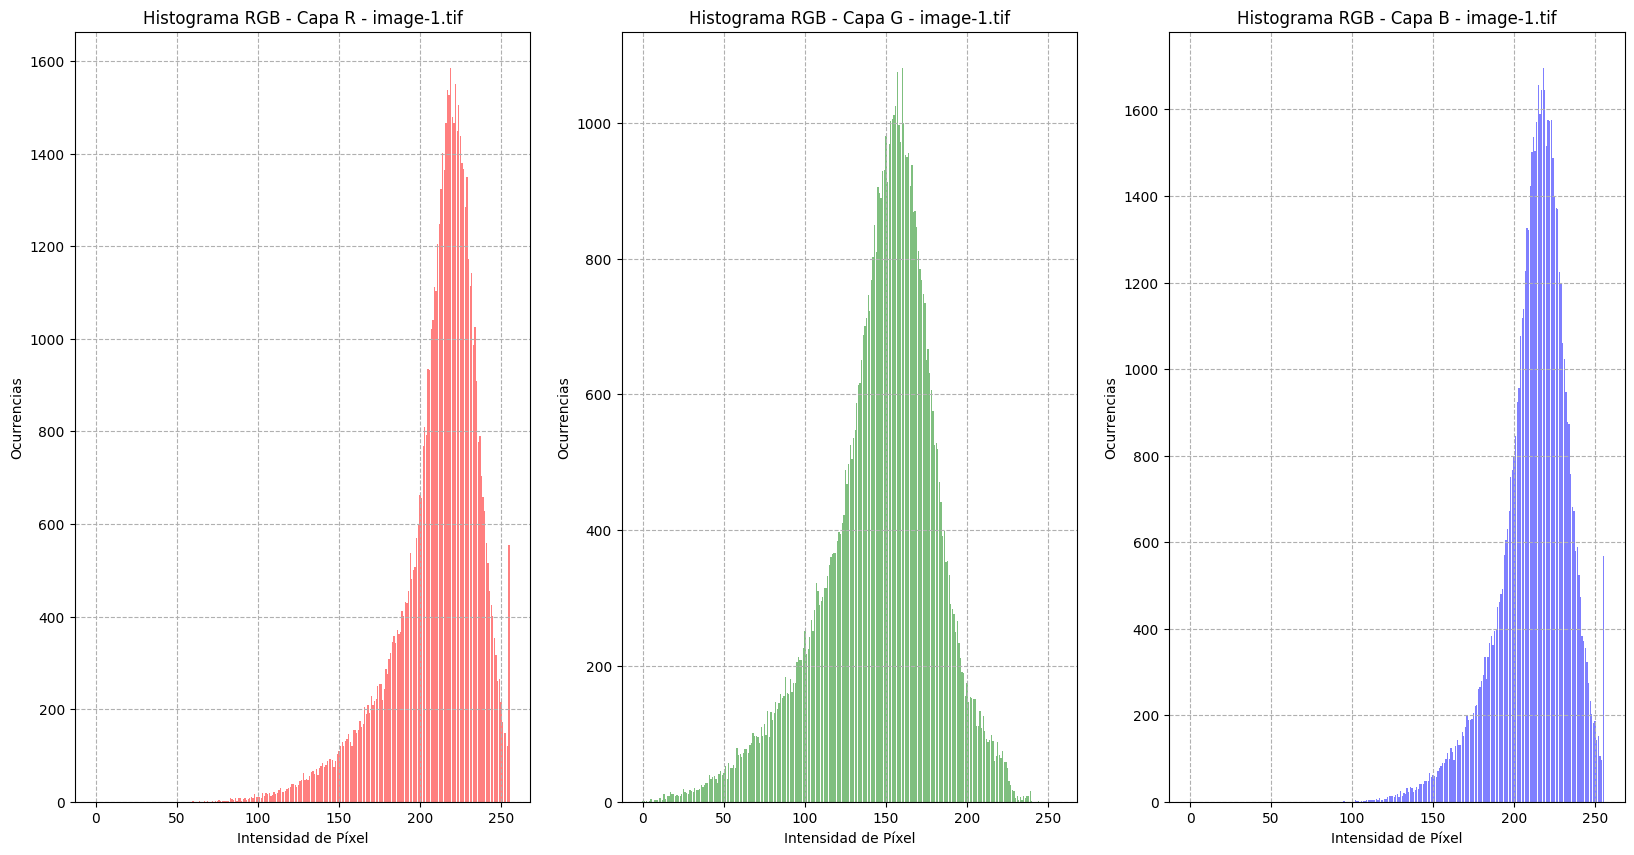

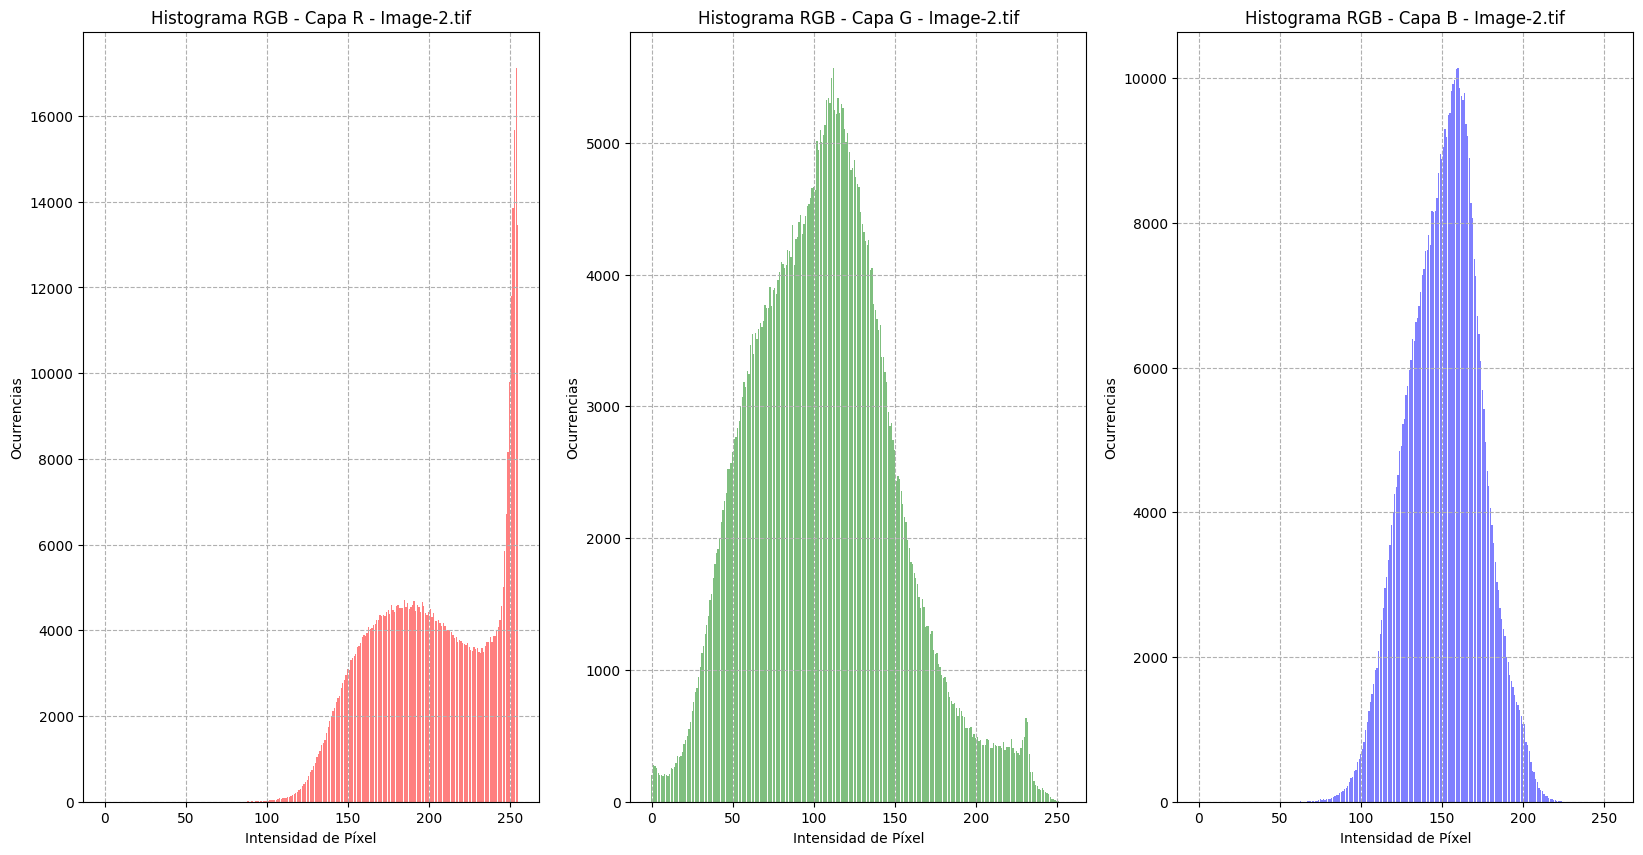

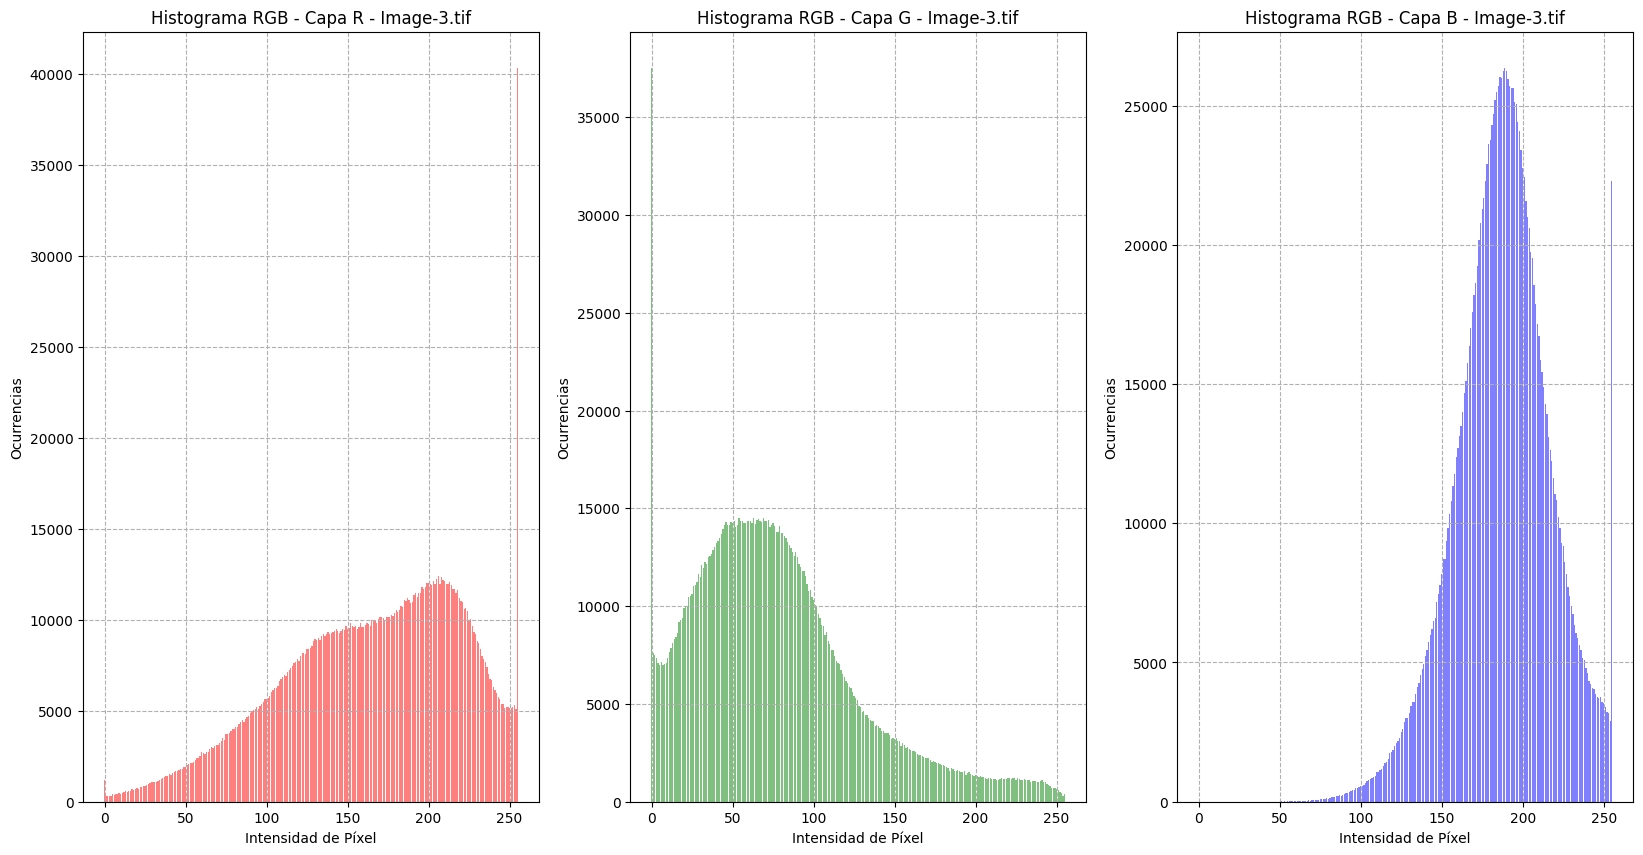

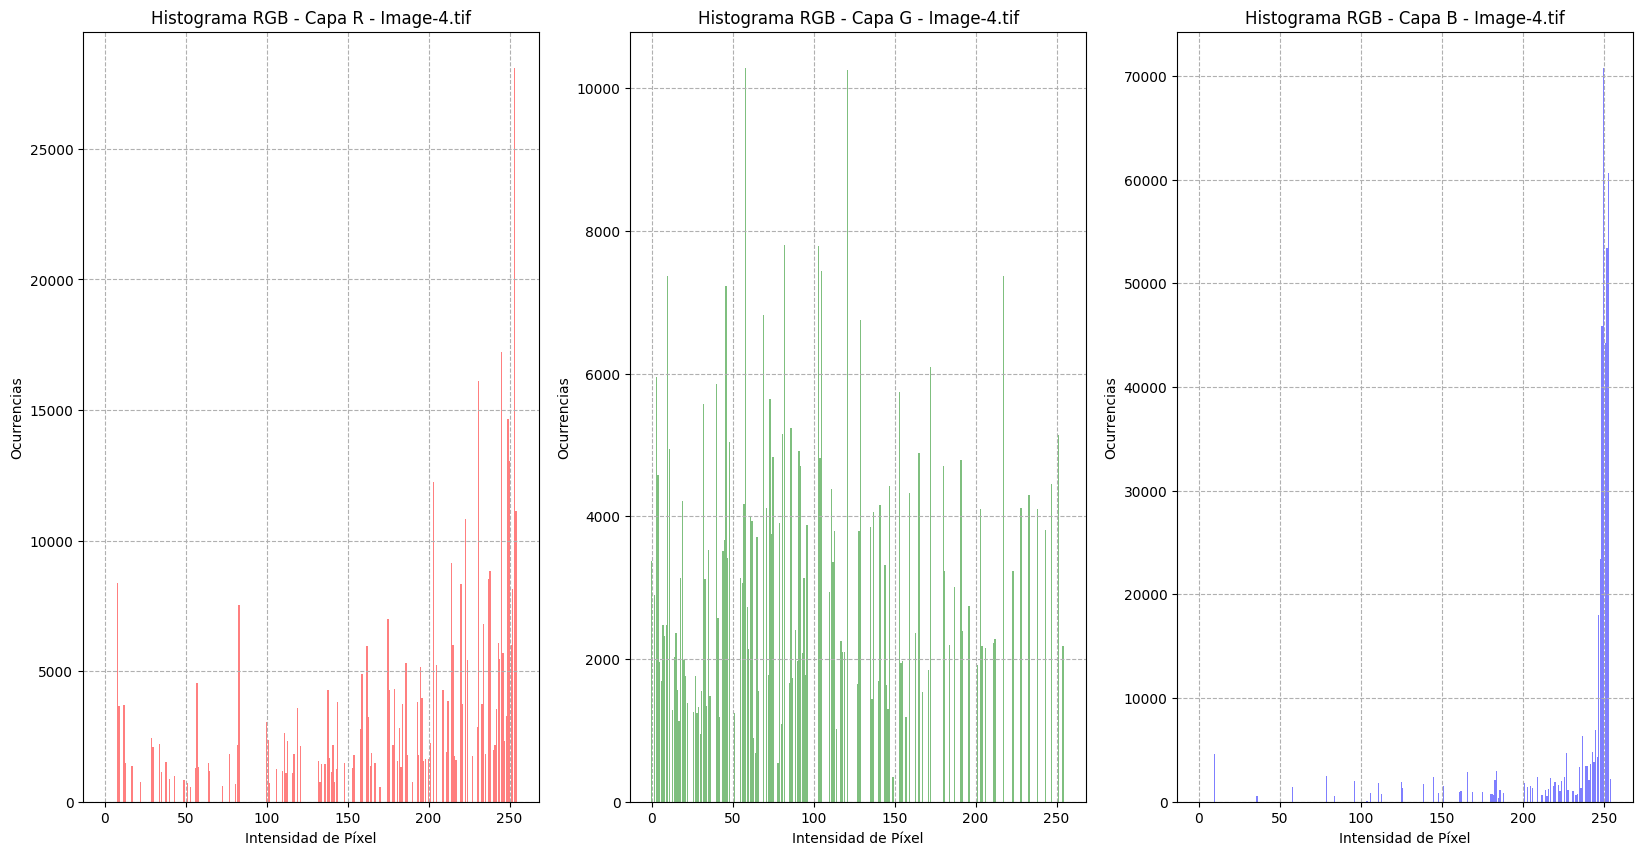

In [10]:
for img,name in zip(imgs_folder_rgb,[*dict_folder.keys()]):
    plotHistograms(img,name,mode='RGB')

## Imágenes en formato YUV

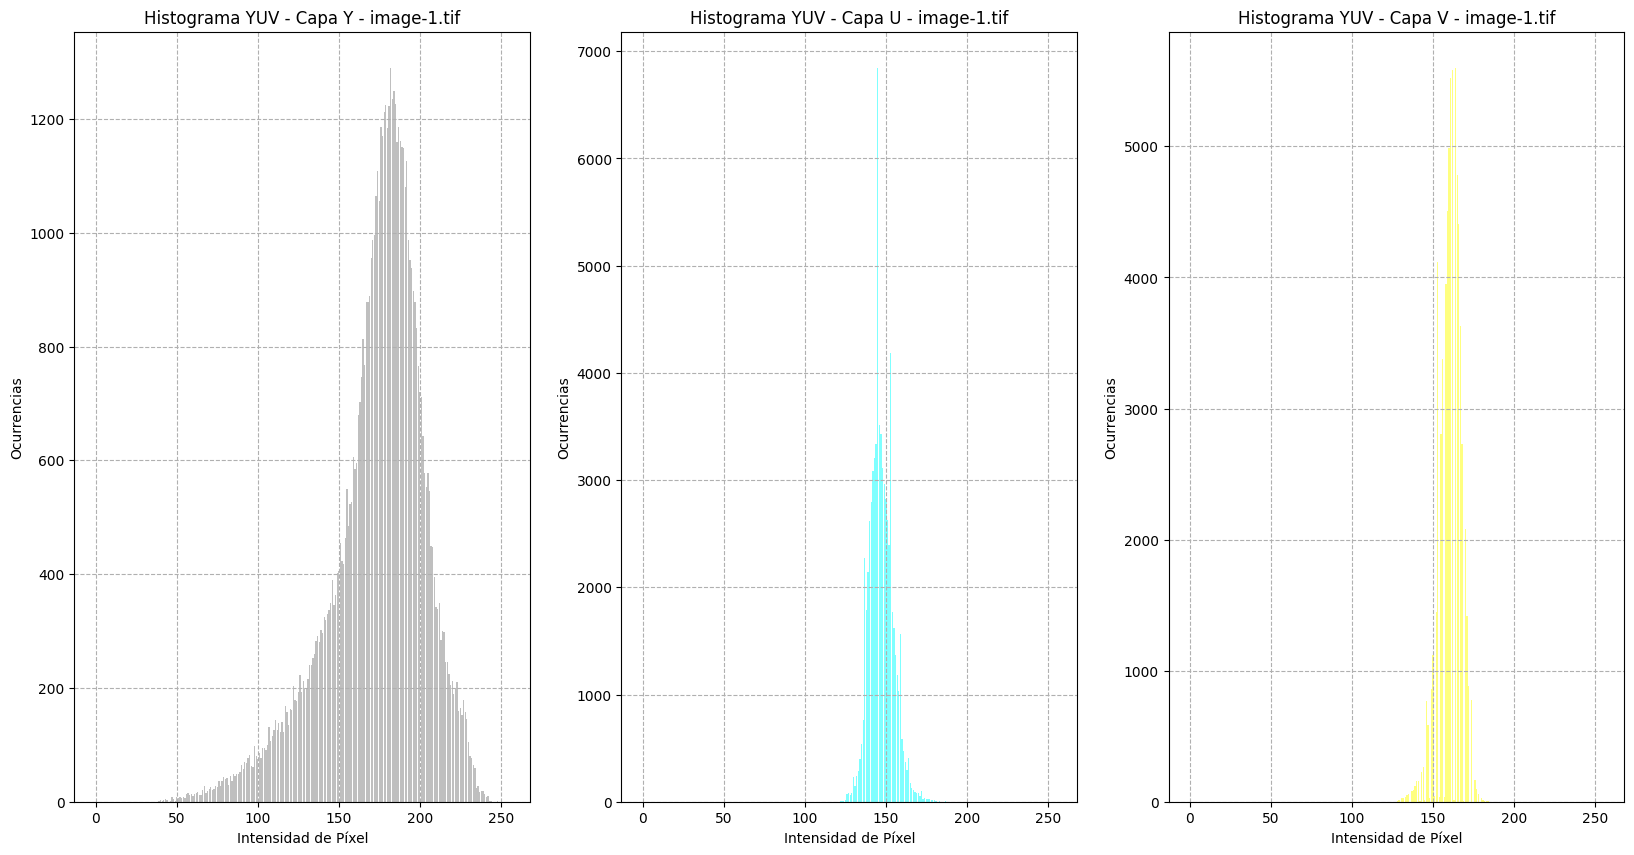

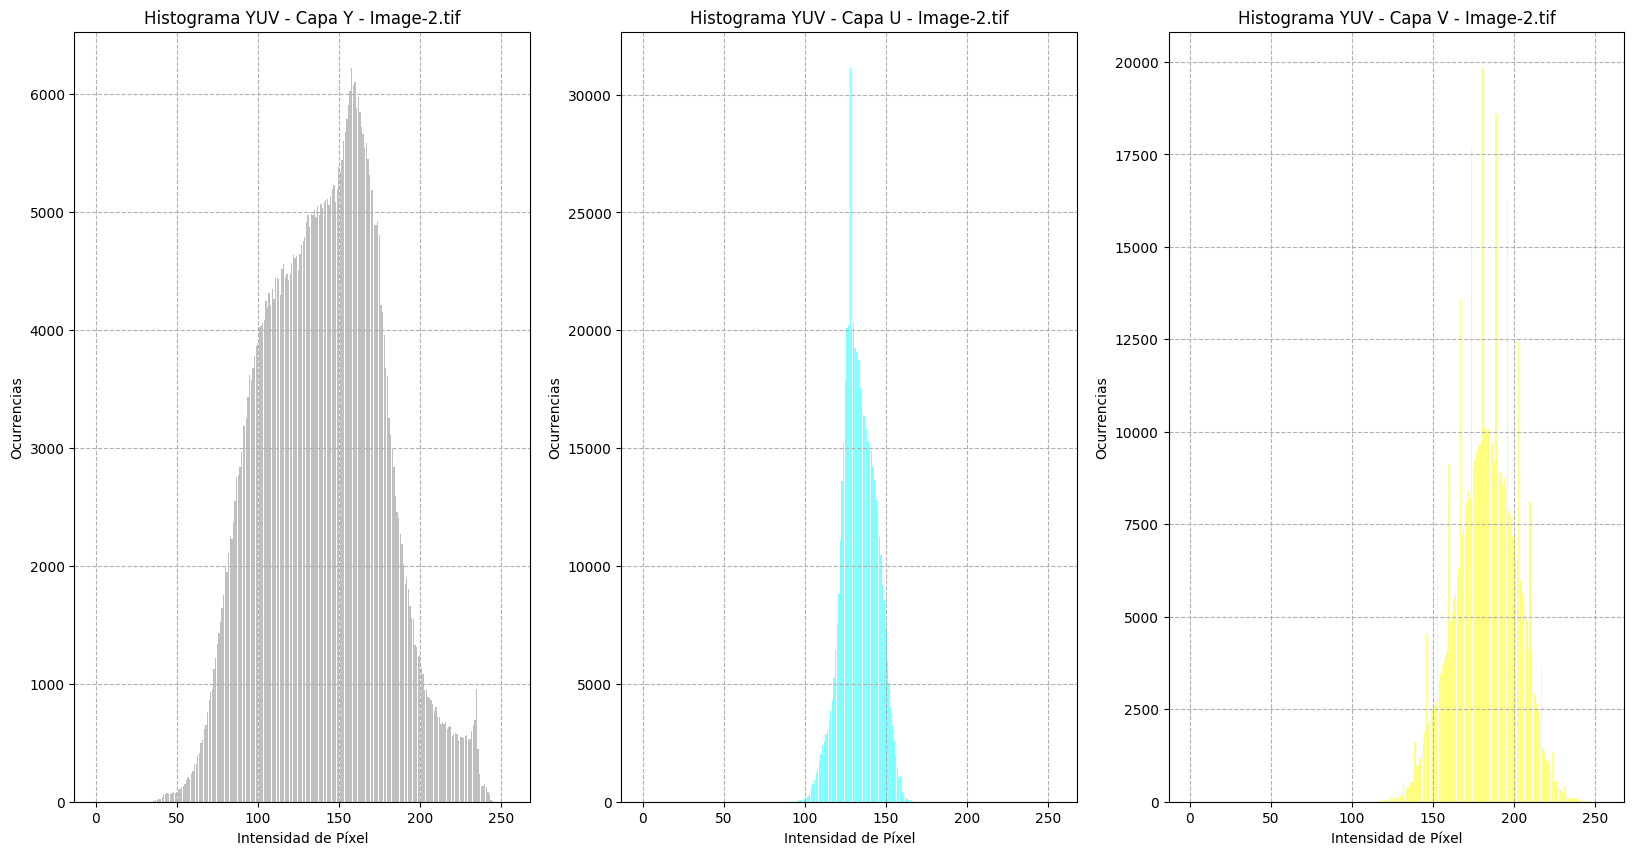

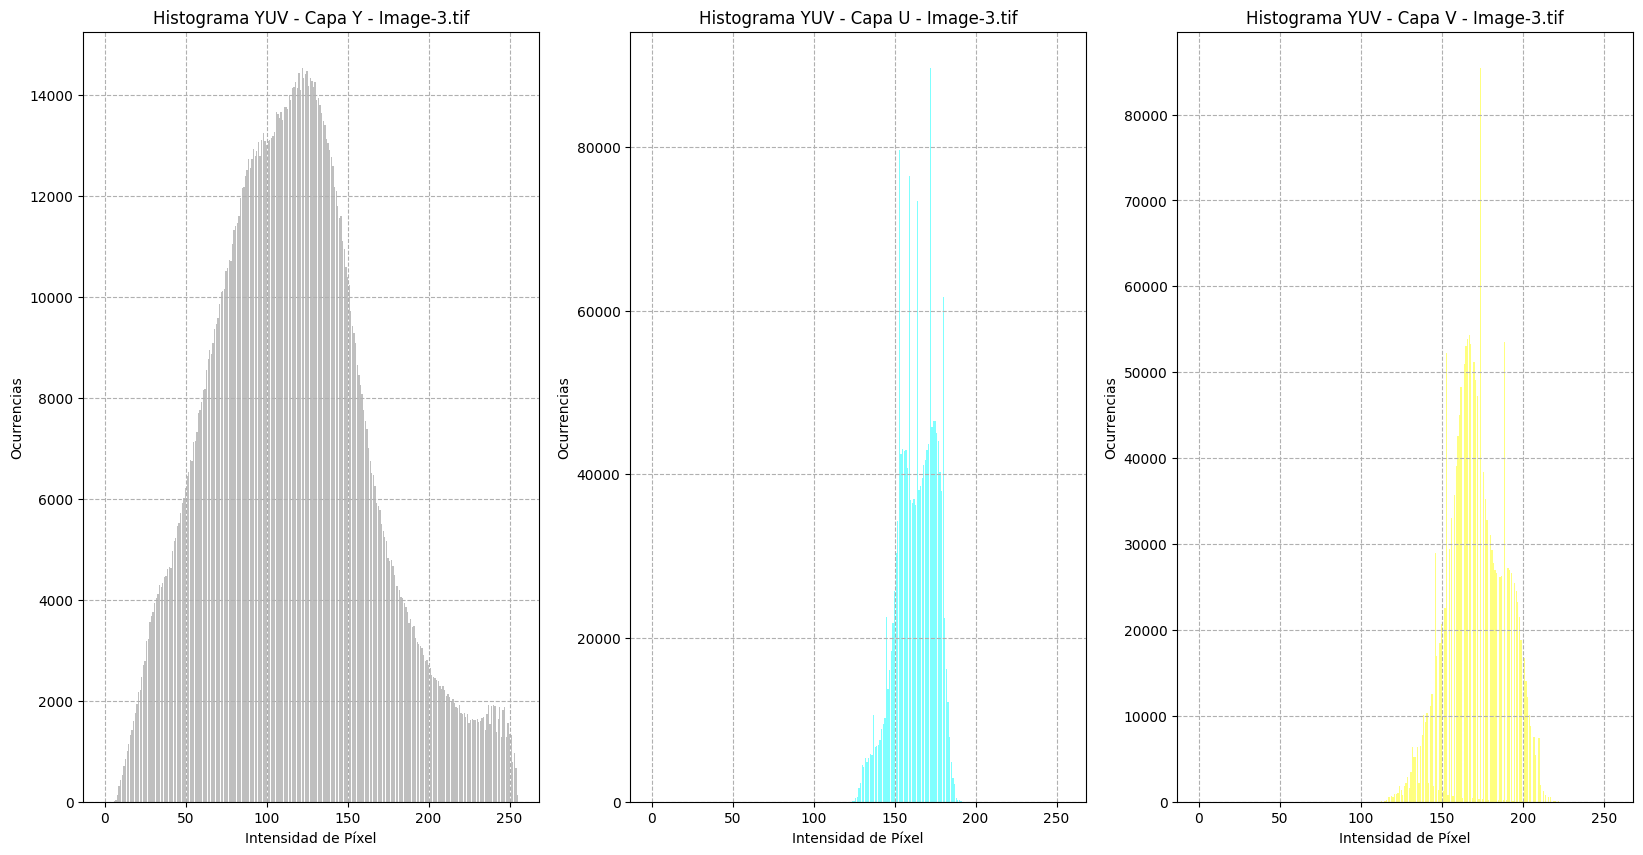

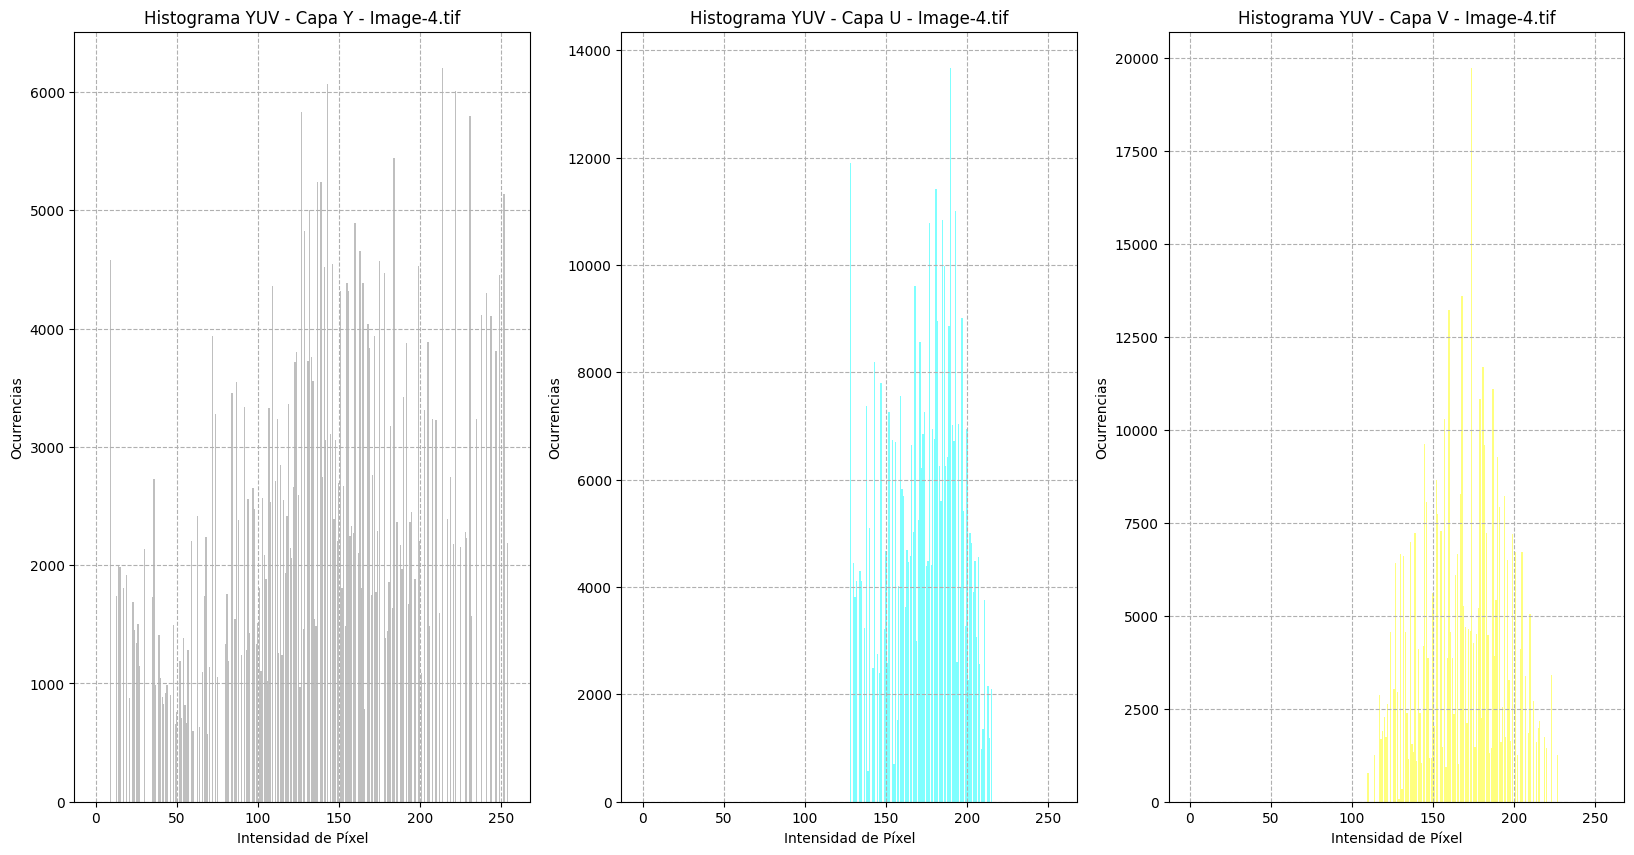

In [11]:
for img,name in zip(imgs_folder_yuv,[*dict_folder.keys()]):
    plotHistograms(img,name,mode='YUV')

## Imágenes en formato HSV

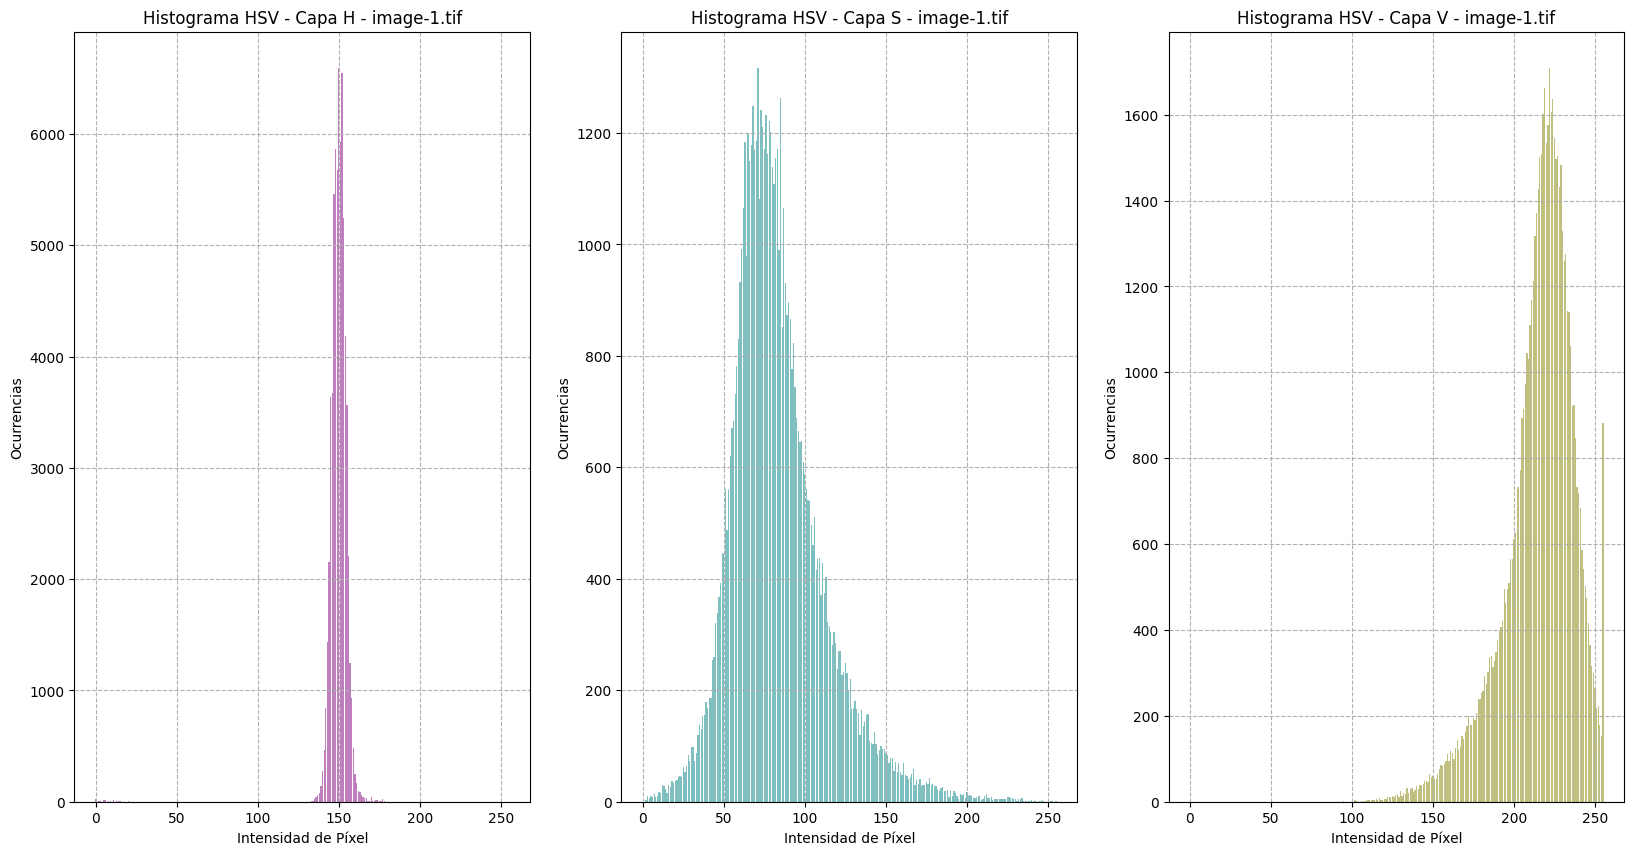

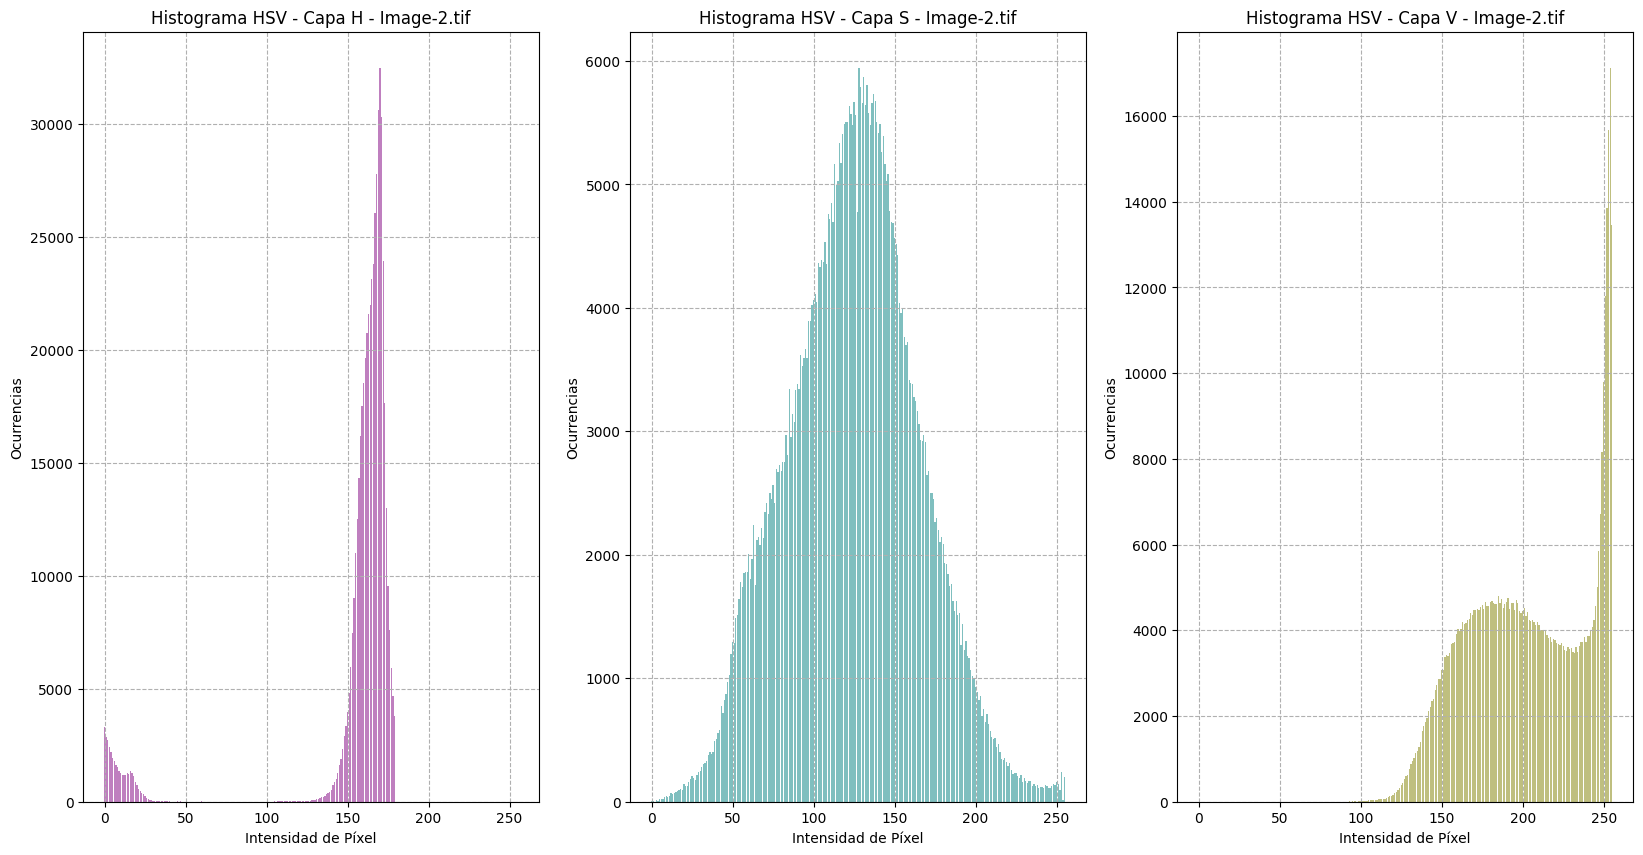

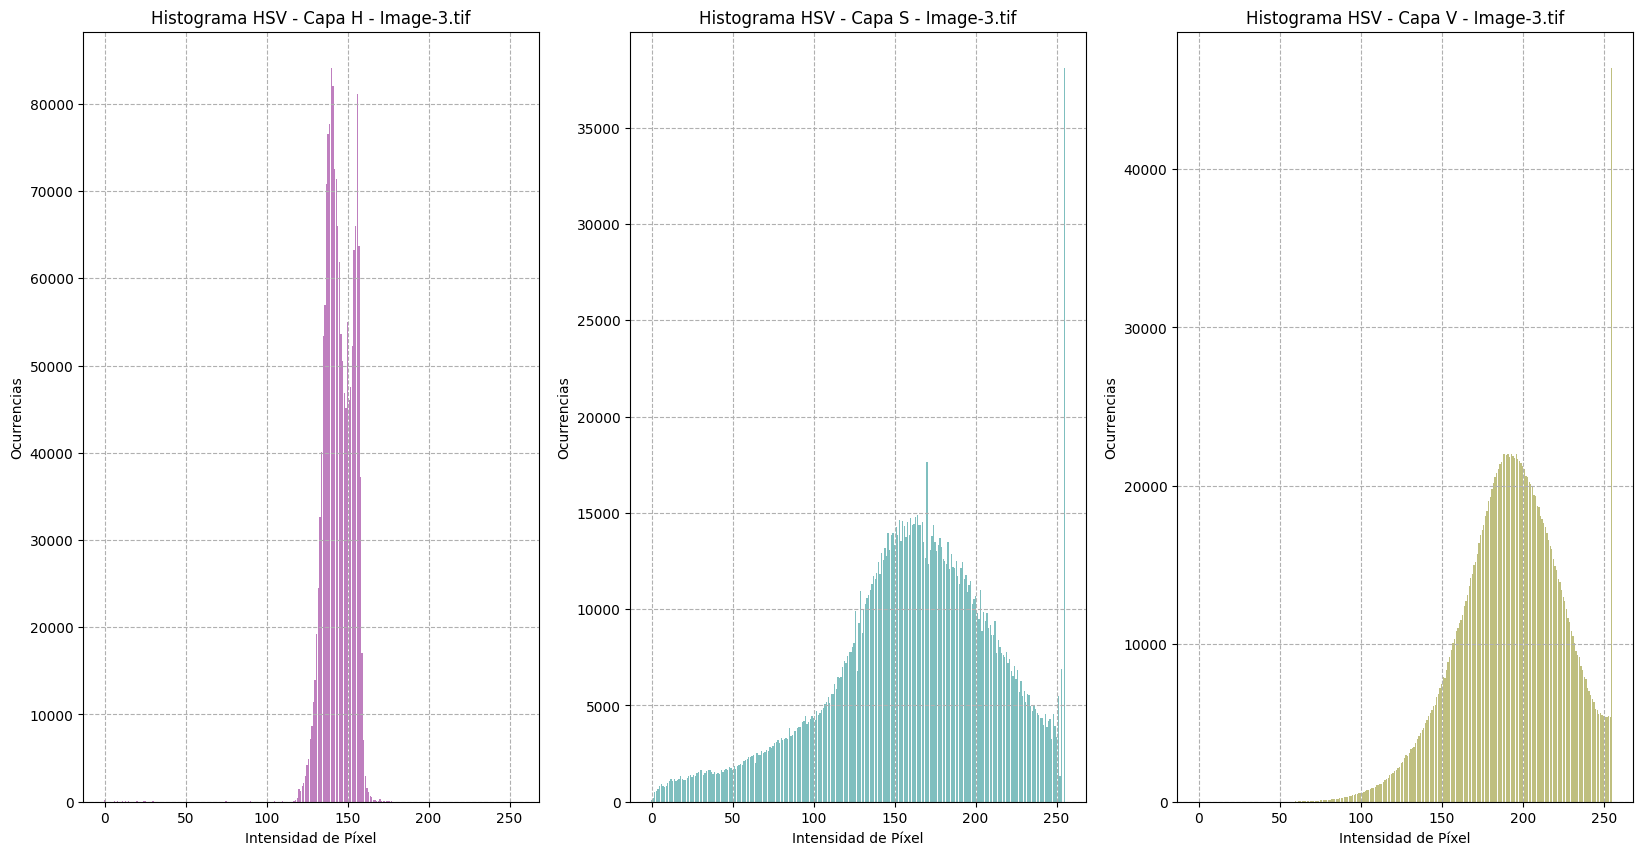

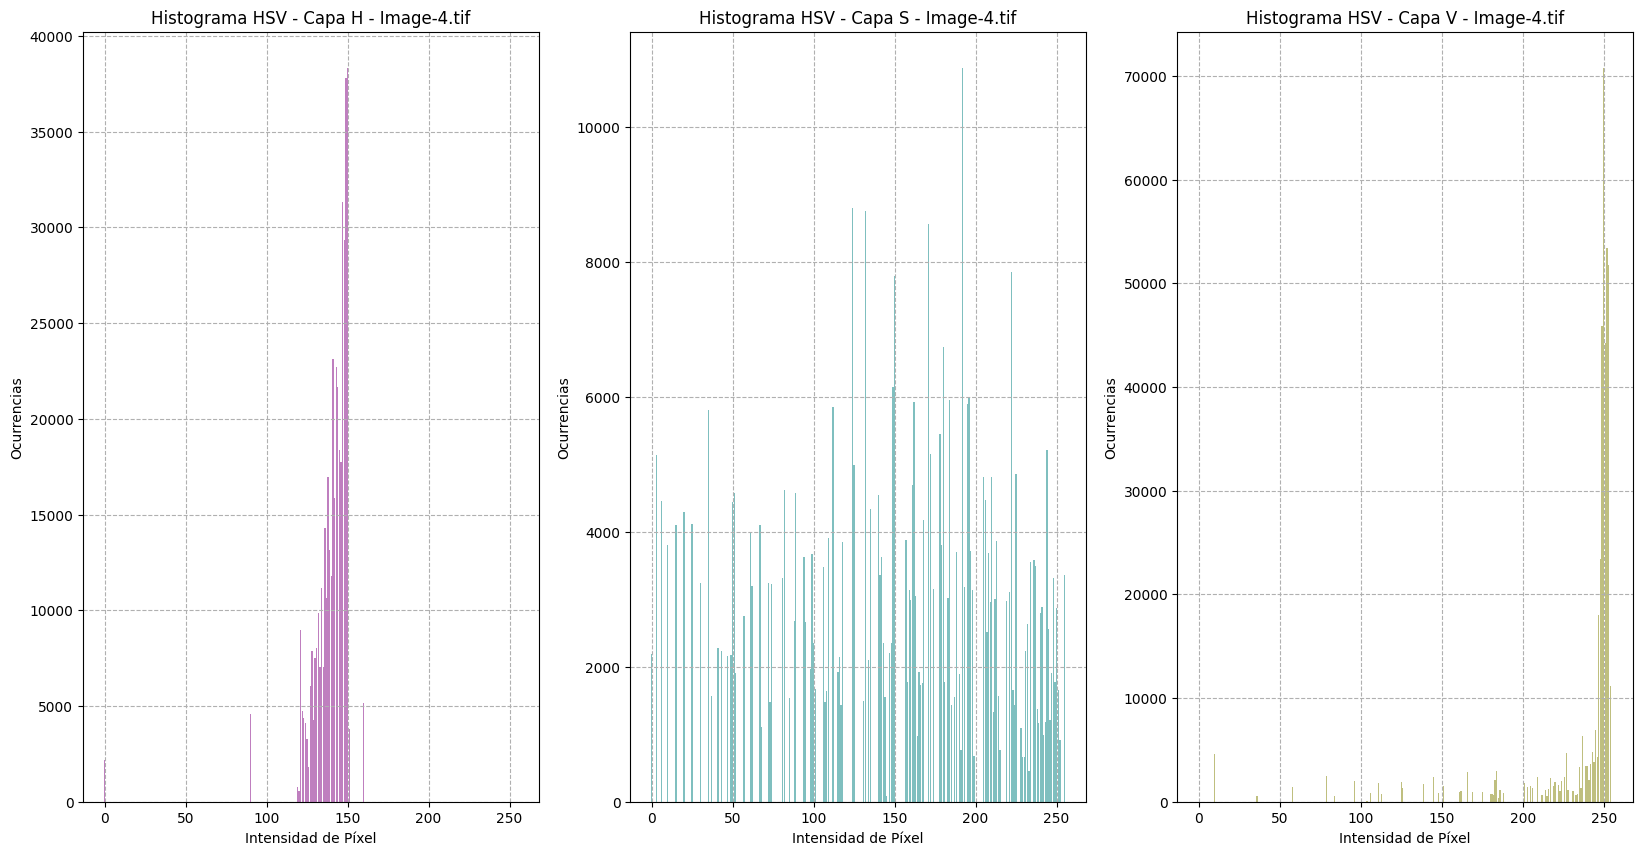

In [12]:
for img,name in zip(imgs_folder_hsv,[*dict_folder.keys()]):
    plotHistograms(img,name,mode='HSV')

# Autocorrelogramas de color

## Definición de clases junto a sus métodos

In [13]:
class autocorrelogram:
    def __init__(self,img:np.ndarray,dist:int=1,bins:int=256,resize_img=False,new_width=300):
        self.img            = img
        self.dist           = dist
        self.bins           = bins
        self.img_shape      = np.shape(img)
        self.resize_img     = resize_img
        self.new_width      = new_width
        
        self.mtz_padd       = 0
        self.contador       = 0
    
    # Público
    
    def resize_with_aspect_ratio(self, width=None, height=None):
        # Dimensiones originales
        h, w = self.img.shape[:2]

        # Cálculo de la relación de aspecto
        aspect_ratio = w / h

        if width is None:
            # Cálculo de la altura basado en el ancho especificado
            new_height = int(height / aspect_ratio)
            resized_image = cv2.resize(self.img, (height, new_height))
        else:
            # Cálculo del ancho basado en la altura especificada
            new_width = int(width * aspect_ratio)
            resized_image = cv2.resize(self.img, (new_width, width))

        return resized_image
    
    def calcQuantizationRGBImg(self):

        #1- Cálculo del divisor
        divisor = np.uint8(256/self.bins)

        #2-Cuantización de la imagen
        if self.resize_img == False:
            qimg = divisor*np.uint8(self.img/divisor)
        else:
            qimg = divisor*np.uint8(self.resize_with_aspect_ratio(width=self.new_width)/divisor)

        return qimg
    
    def getUniqueRGBColors(self):

        #1-Cálculo de la imagen cuantizada
        qimg = self.calcQuantizationRGBImg()
        
        qimg_shape = np.shape(qimg)
        
        #2- Redimensión de la imagen
        new_arr_lenght = qimg_shape[0]*qimg_shape[1]
        reshape_img = np.reshape(qimg,[new_arr_lenght,3])

        #3- Obtención de los colores componentes de la img
        unique_colors = [i for i in np.unique(reshape_img,axis=0)]
        unique_colors = np.uint8(unique_colors)
        
        return unique_colors
    
    def getAllOcurrencies(self):
        qimg        = self.calcQuantizationRGBImg()
        qimg_colors = self.getUniqueRGBColors()
        
        arr_ocurrencies = [autocorrelogram.__getOcurrenciesForColor(self=self,qimg=qimg,color=color) for color in qimg_colors]

        return arr_ocurrencies
    
    # Privado
    
    def __vectorEquality(self,vector1,vector2):
        if np.array_equal(vector1, vector2):
            return 1
        else:
            return 0
        
    def __validationTransform(self,arr):
        arr[arr != self.dist] = 0
        arr[arr == self.dist] = 1
        return arr
    
    def __countOcurrencies(self,i,j):
        
        mtz_sliced = np.copy(self.mtz_padd)
        
        mtz_sliced = mtz_sliced[(i-self.dist):(i+self.dist+1),(j-self.dist):(j+self.dist+1)]

        new_indices = np.nonzero(mtz_sliced)
        
        new_arr_coor = [[x,y] for x,y in zip(new_indices[0],new_indices[1])]
        
        new_arr_distances = np.round(np.ravel(sp_dist.cdist(XA=new_arr_coor,XB=np.array([[self.dist,self.dist]]))))
        
        arr_validation = self.__validationTransform(arr=new_arr_distances)

        sum_for_coor = np.float64(np.sum(arr_validation))
        
        #Suma al contador
        self.contador = self.contador + sum_for_coor
        
        #Elimino de la matriz de paddeo a la coordenada analizada
        self.mtz_padd[i][j] = 0
        
    def __getOcurrenciesForColor(self,qimg,color):
        
        qimg_shape = np.shape(qimg)
        
        self.contador = 0
        
        img_lenght = qimg_shape[0]*qimg_shape[1]
        
        reshape_img = np.reshape(qimg,[img_lenght,3])
        
        # Binarización de la imagen a partir del color dado
        img_only_color = [self.__vectorEquality(vector1=reshape_img[i],vector2=color) for i in range(len(reshape_img))]
        
        img_only_color = np.reshape(img_only_color,[qimg_shape[0],qimg_shape[1]])
        
        # Paddeo de filas y columnas
        img_only_color_padding = np.pad(img_only_color, pad_width=((self.dist, self.dist), (self.dist, self.dist)), mode='constant', constant_values=0)
        
        self.mtz_padd = np.copy(img_only_color_padding)
        
        # Obtención de índices de la imagen binarizada que no son igual a 0
        nonzero_indices = np.nonzero(img_only_color_padding)
        
        # NUEVO
        nolist = [self.__countOcurrencies(i=i,j=j) for i,j in zip(nonzero_indices[0],nonzero_indices[1])]
        
        return self.contador



In [14]:
class autocorrelogramPlots:
    def __init__(self,unique_colors,ocurrencies,dist,bins,img_name='name') -> None:
        
        self.unique_colors      = unique_colors
        self.ocurrencies        = np.uint64(ocurrencies)
        self.dist               = dist
        self.bins               = bins
        self.img_name           = img_name
        
        self.__colores_R        = np.array([self.unique_colors[i][0] for i in range(len(self.unique_colors))])
        self.__colores_G        = np.array([self.unique_colors[i][1] for i in range(len(self.unique_colors))]) 
        self.__colores_B        = np.array([self.unique_colors[i][2] for i in range(len(self.unique_colors))]) 
        
        self.unique_colors_R    = np.unique(self.__colores_R)
        self.unique_colors_G    = np.unique(self.__colores_G)
        self.unique_colors_B    = np.unique(self.__colores_B)
    
    # Público
    
    def getOcurrenciesByLayer(self):
        
        arr_colors_for_layer = [self.__colores_R,self.__colores_G,self.__colores_B]
        arr_ocurrencies_by_layer = [self.__sumOcurrenciesForLayer(colors_layer=i) for i in arr_colors_for_layer]

        return arr_ocurrencies_by_layer
    
    def autocorrelogramComplete(self):
        plt.figure(figsize=(20,10))
        plt.bar(np.arange(len(self.unique_colors)),self.ocurrencies)
        plt.yscale('log')
        plt.xticks(ticks=np.arange(len(self.unique_colors)))
        plt.grid(linestyle='--')
        plt.xlabel(f"Colores RGB únicos de la imagen cuantizada - Bins: {self.bins}")
        plt.ylabel("Ocurrencias")
        plt.title(f"Autocorrelograma - {self.img_name} - Distancia: {self.dist}")
        plt.show()

    def autocorrelogramEachLayer(self):
        
        arr_ocurrencies_by_layer = self.getOcurrenciesByLayer()
        
        fig = plt.figure(figsize=(20,10))

        ax = fig.add_subplot(1,3,1)
        ax.bar(np.arange(len(self.unique_colors_R)),
               arr_ocurrencies_by_layer[0],
               color='red',
               alpha=0.5)
        ax.set_yscale('log')
        ax.grid(linestyle='--')
        ax.set_xticks(ticks=np.arange(len(self.unique_colors_R)),labels=self.unique_colors_R)
        ax.set_xlabel(f"Colores únicos de la capa R - Bins: {self.bins}")
        ax.set_ylabel("Ocurrencias")
        ax.set_title(f"Autocorrelograma - Capa R - {self.img_name} - Distancia: {self.dist}")
        
        ax = fig.add_subplot(1,3,2)
        ax.bar(np.arange(len(self.unique_colors_G)),
               arr_ocurrencies_by_layer[1],
               color='green',
               alpha=0.5)
        ax.set_yscale('log')
        ax.grid(linestyle='--')
        ax.set_xticks(ticks=np.arange(len(self.unique_colors_G)),labels=self.unique_colors_G)
        ax.set_xlabel(f"Colores únicos de la capa G - Bins: {self.bins}")
        ax.set_ylabel("Ocurrencias")
        ax.set_title(f"Autocorrelograma - Capa R - {self.img_name} - Distancia: {self.dist}")
        
        ax = fig.add_subplot(1,3,3)
        ax.bar(np.arange(len(self.unique_colors_B)),
               arr_ocurrencies_by_layer[2],
               color='blue',
               alpha=0.5)
        ax.set_yscale('log')
        ax.grid(linestyle='--')
        ax.set_xticks(ticks=np.arange(len(self.unique_colors_B)),labels=self.unique_colors_B)
        ax.set_xlabel(f"Colores únicos de la capa B - Bins: {self.bins}")
        ax.set_ylabel("Ocurrencias")
        ax.set_title(f"Autocorrelograma - Capa B - {self.img_name} - Distancia: {self.dist}")

        plt.show()
    
    # Privado
    
    def __sumOcurrenciesForColor(self,colors_layer,color):

        copyocurrencies = np.copy(self.ocurrencies)
        copyocurrencies[colors_layer != color] = 0
        suma = np.sum(copyocurrencies)
        
        return suma

    def __sumOcurrenciesForLayer(self,colors_layer):
        
        arr_unique_colors_for_layer = np.unique(colors_layer)
        arr_sumas = np.array([self.__sumOcurrenciesForColor(colors_layer=colors_layer,color=color) for color in arr_unique_colors_for_layer])
        
        return arr_sumas

In [15]:
def showImgComparison(img,qimg,bins=256,img_name='name'):
    fig = plt.figure(figsize=(20,10))

    ax = fig.add_subplot(1,2,1)
    ax.imshow(img)
    ax.set_title(f"Imagen Original - {img_name}")

    ax = fig.add_subplot(1,2,2)
    ax.imshow(qimg)
    ax.set_title(f"Imagen Cuantizada - {img_name} - Bins: {bins}")

    plt.show()

## Visualización de imagenes originales y cuantizadas

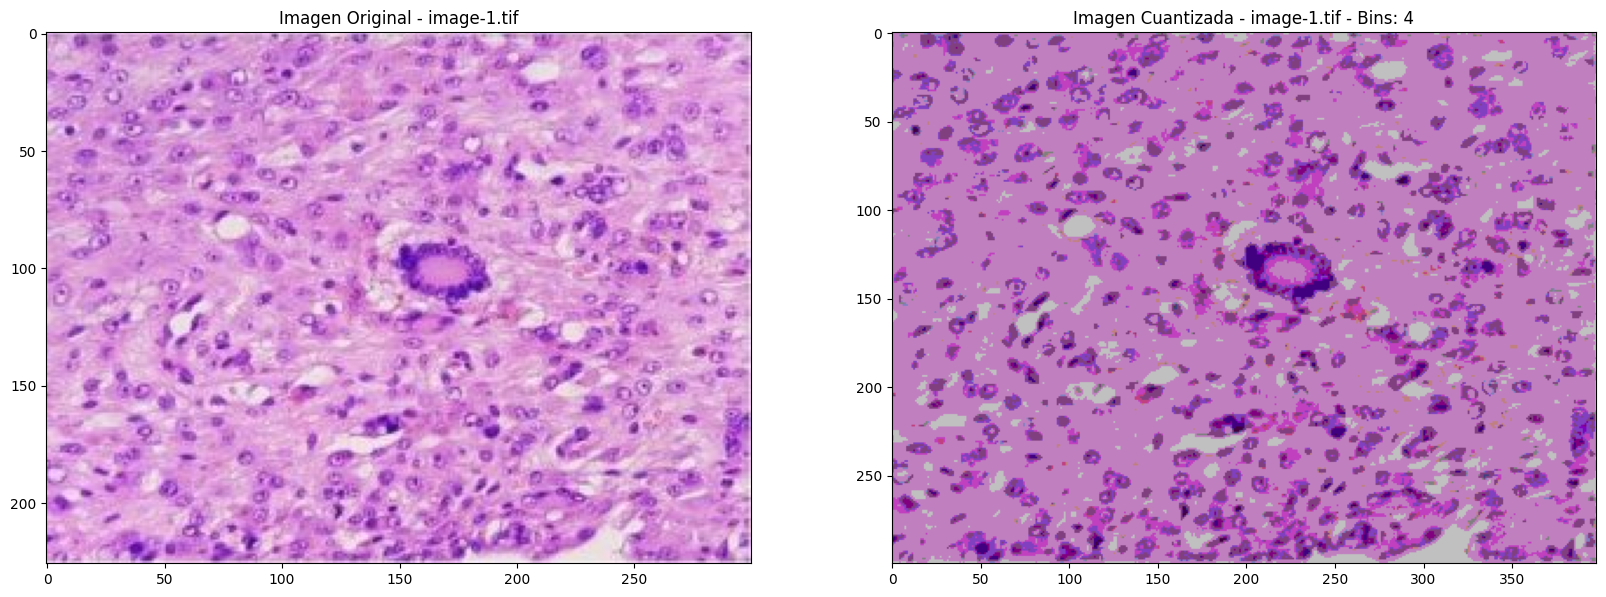

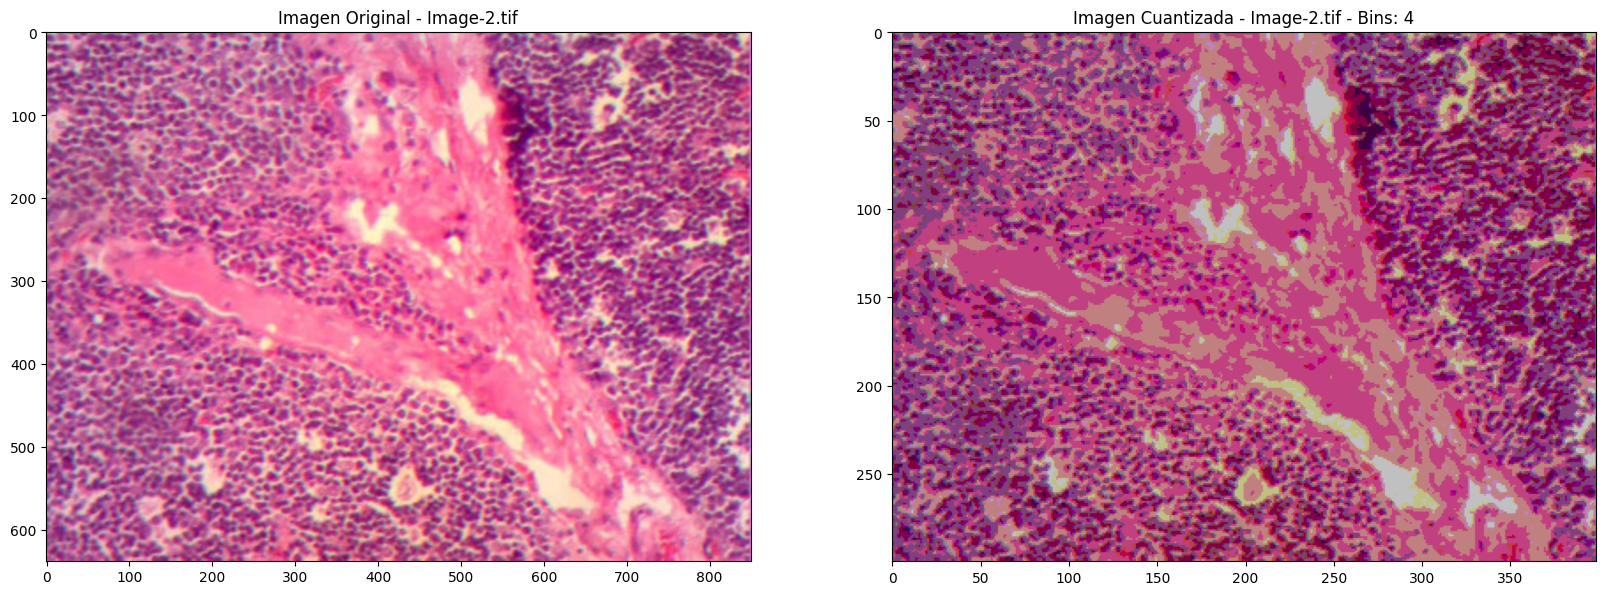

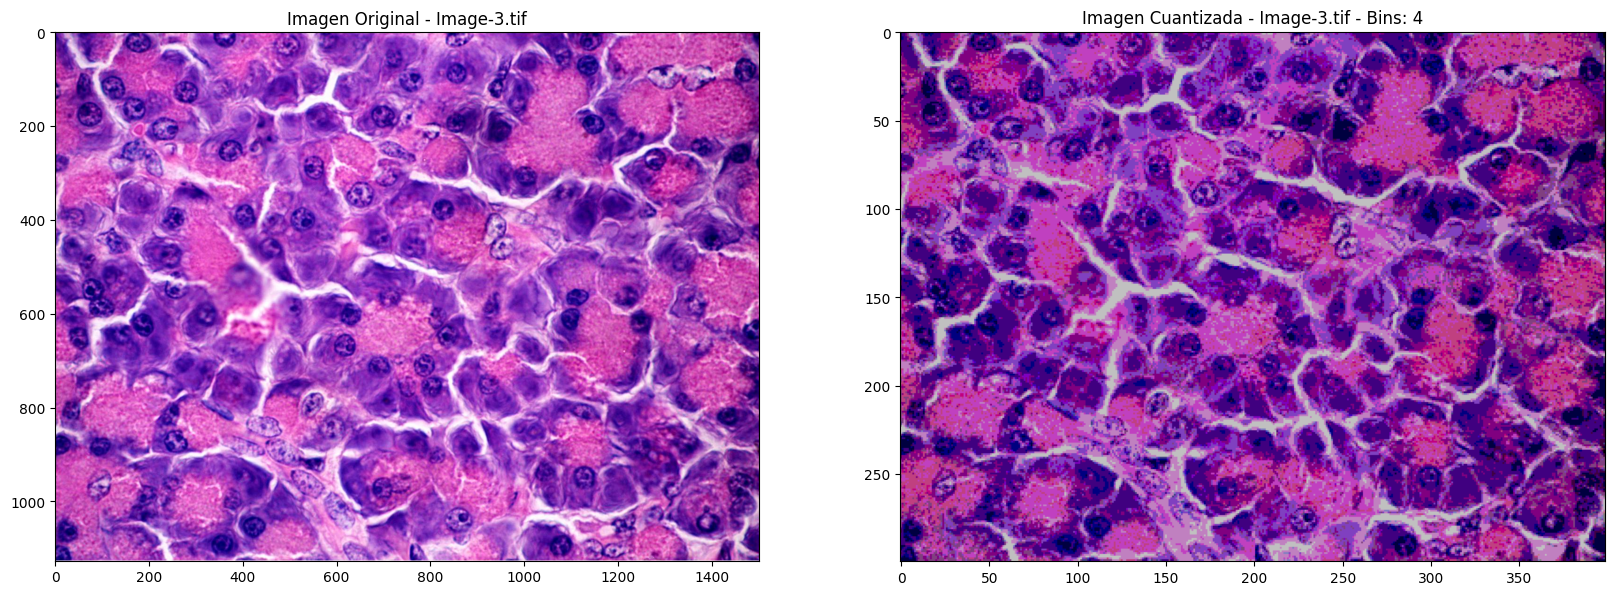

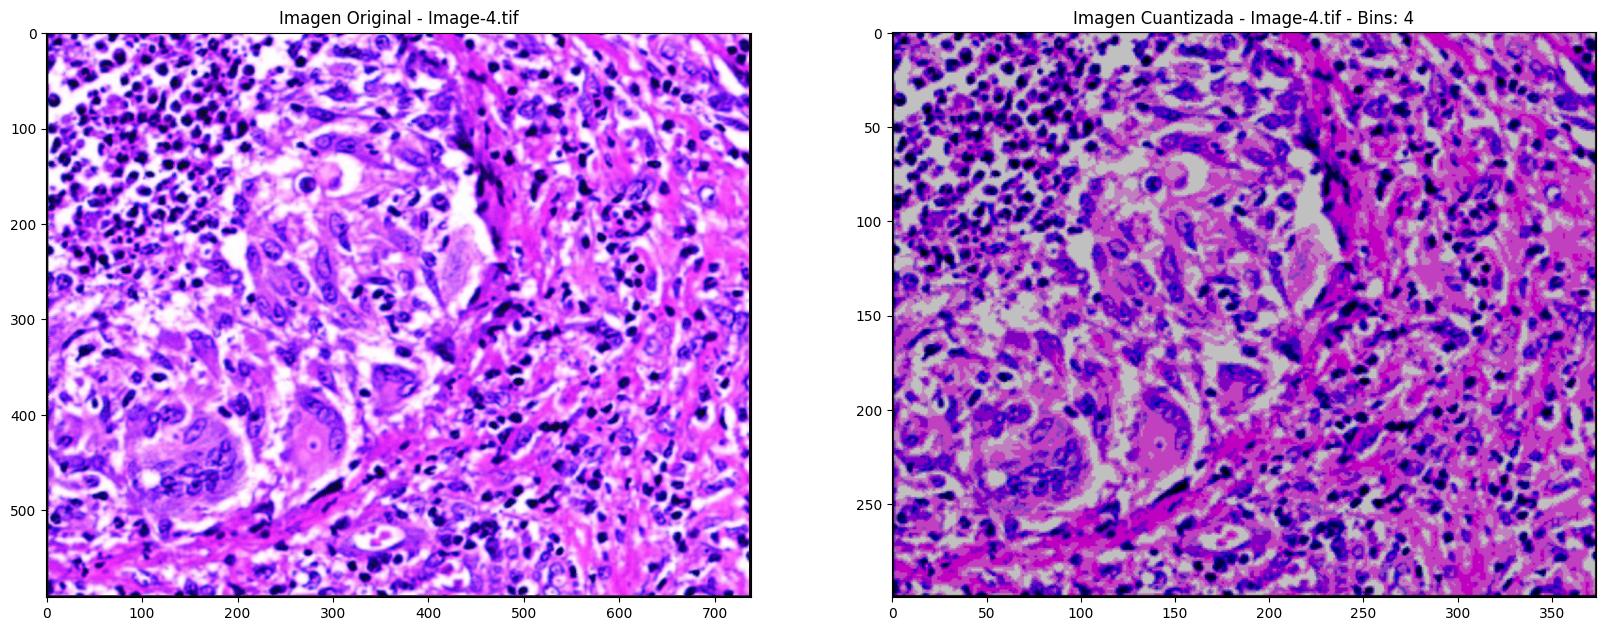

In [16]:
dist=2
bins=4

for img, name in zip(imgs_folder_rgb,[*dict_folder.keys()]):
    qimg = autocorrelogram(img=img,bins=bins,resize_img=True).calcQuantizationRGBImg()
    showImgComparison(img,qimg,bins=4,img_name=name)

## Cálculo de los autocorrelogramas para cada imagen

In [17]:
imgs_unique_colors  = [autocorrelogram(img=img,dist=dist,bins=bins,resize_img=True).getUniqueRGBColors() for img in imgs_folder_rgb]
imgs_ocurrencies    = [autocorrelogram(img=img,dist=dist,bins=bins,resize_img=True).getAllOcurrencies() for img in imgs_folder_rgb]

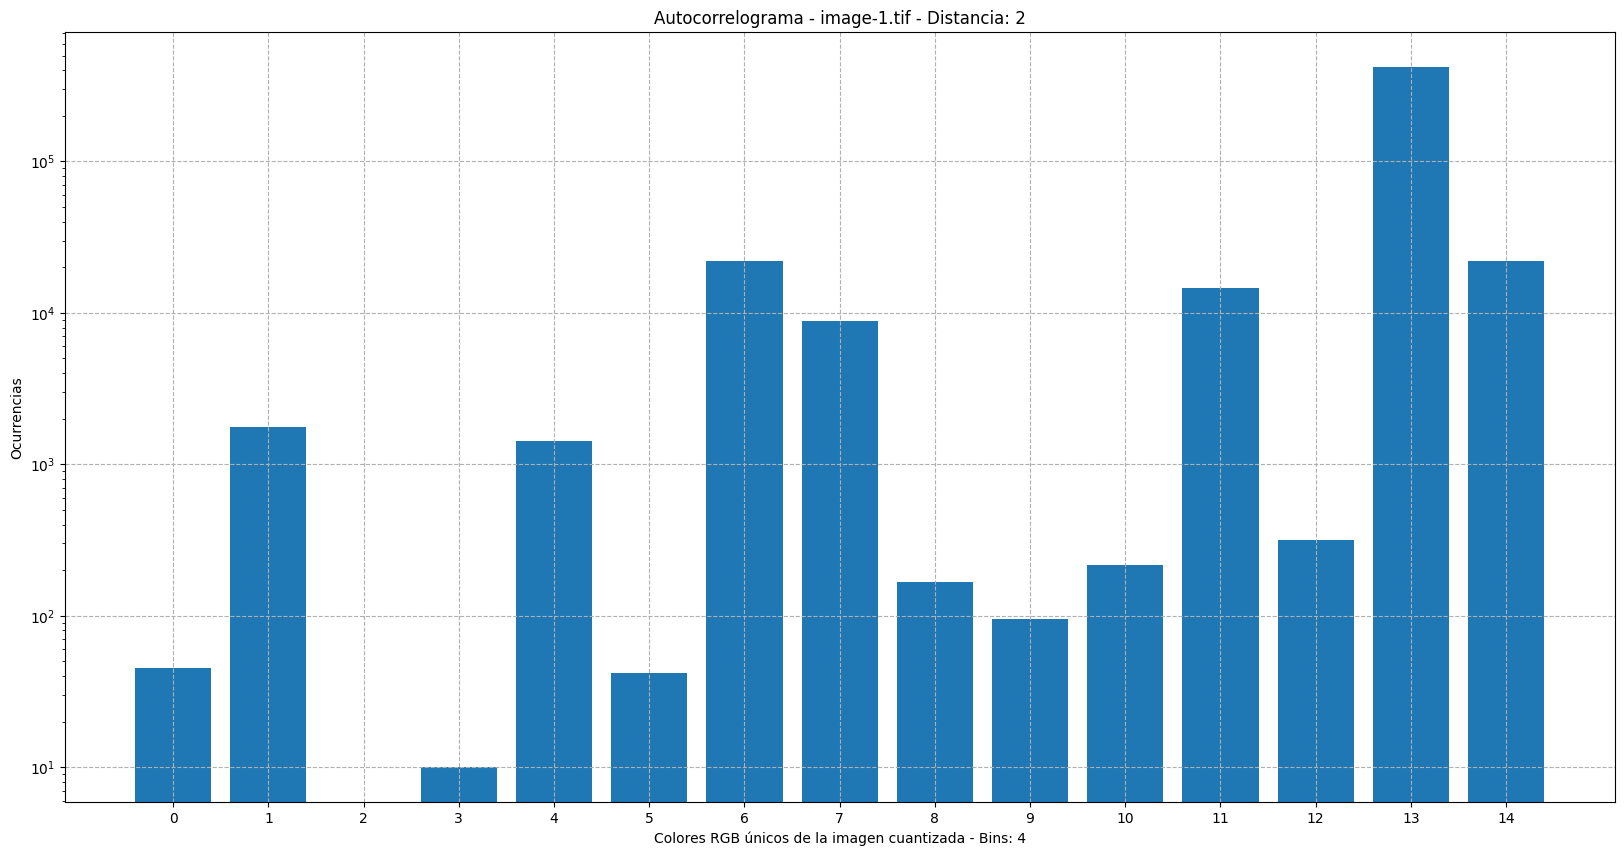

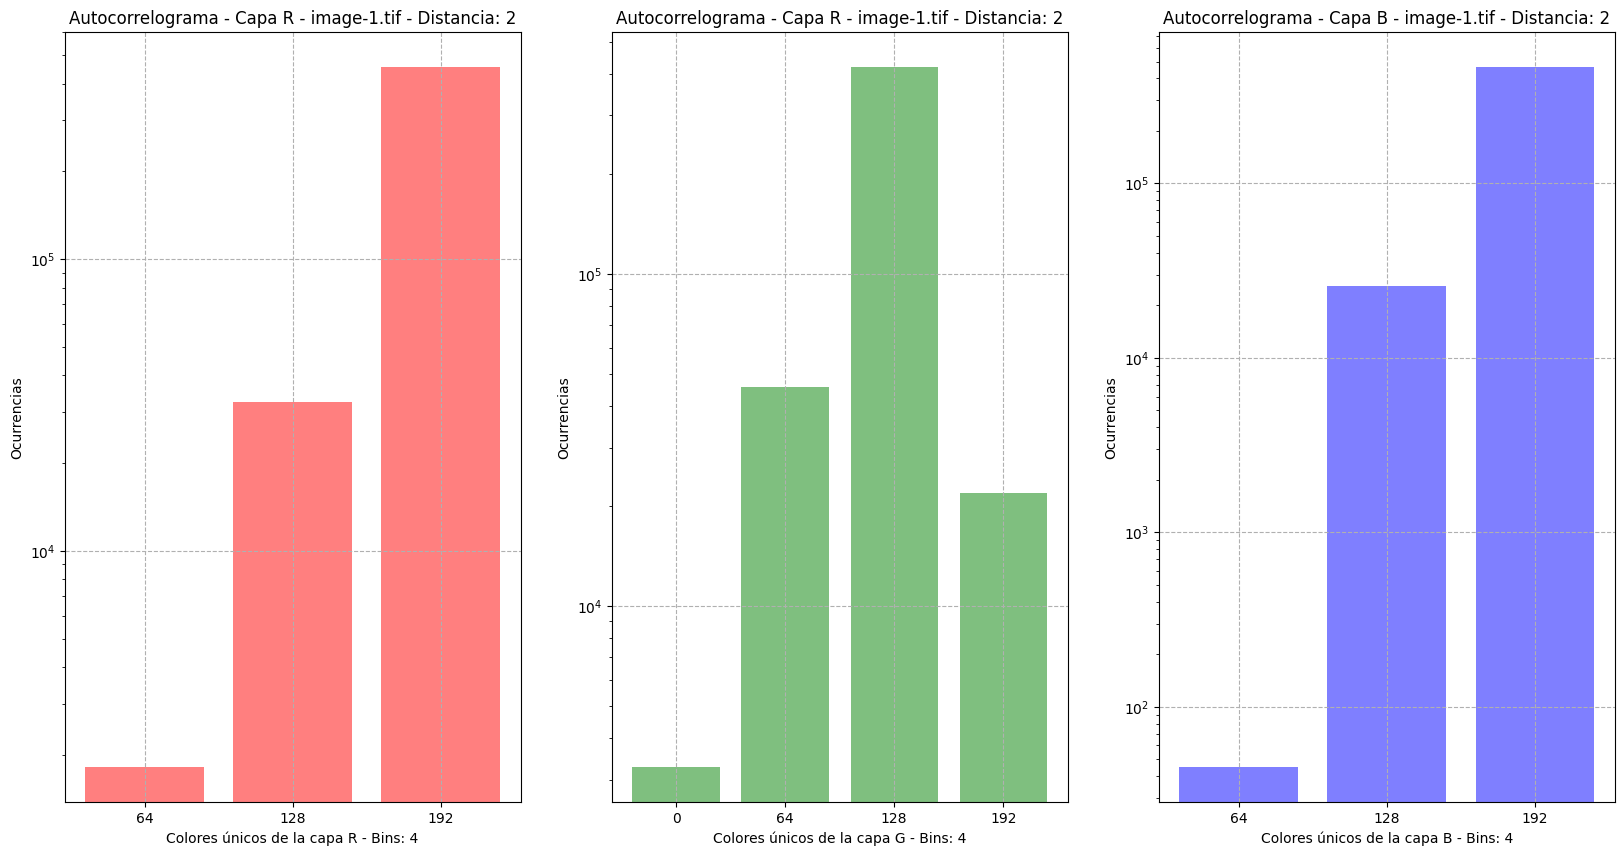

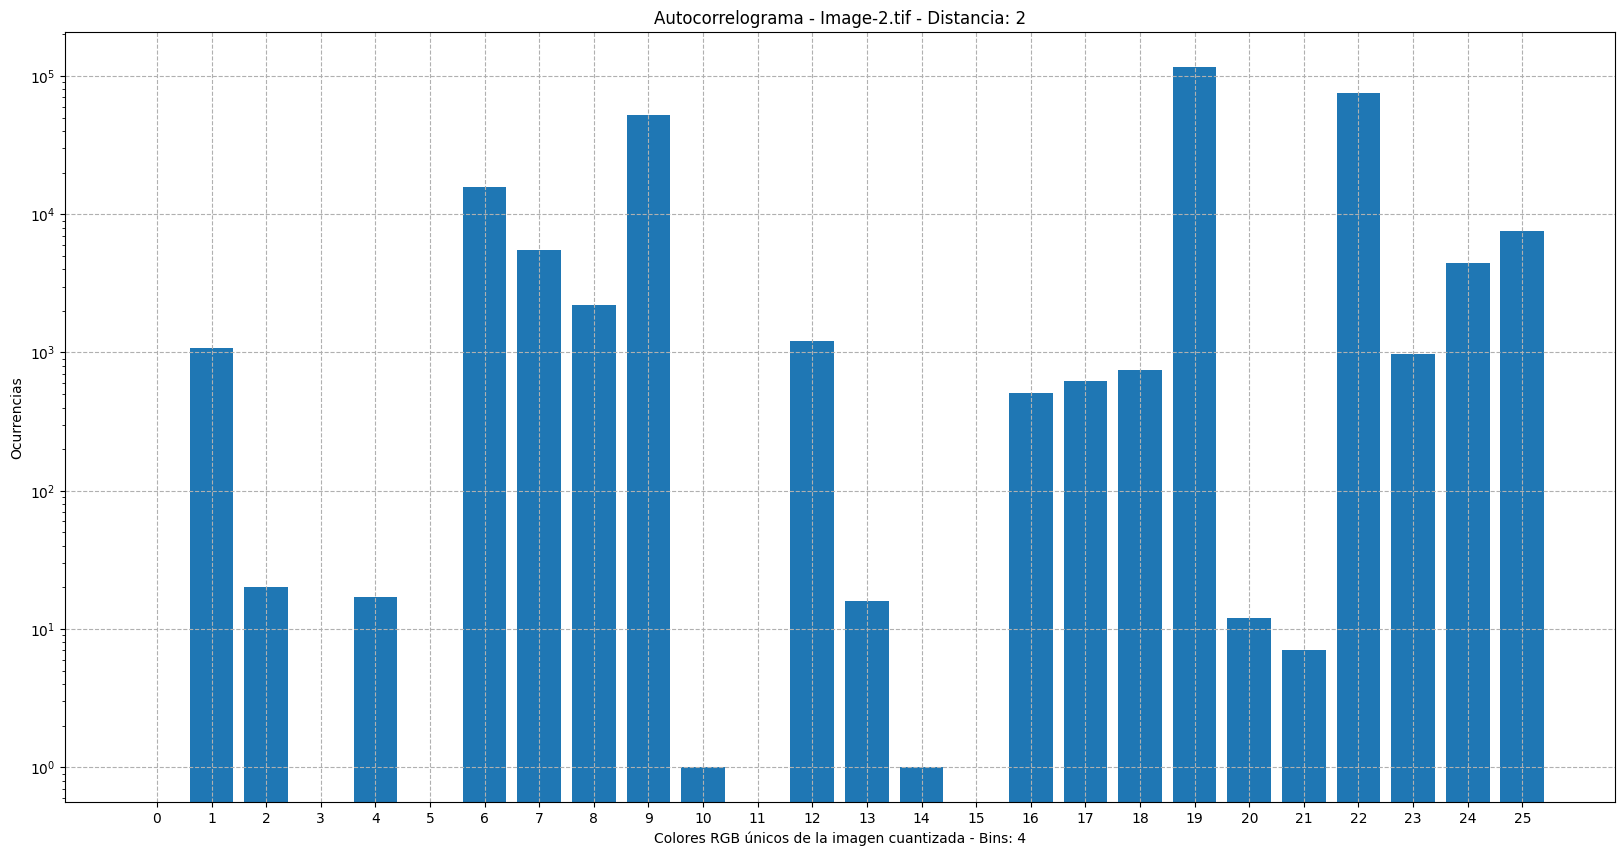

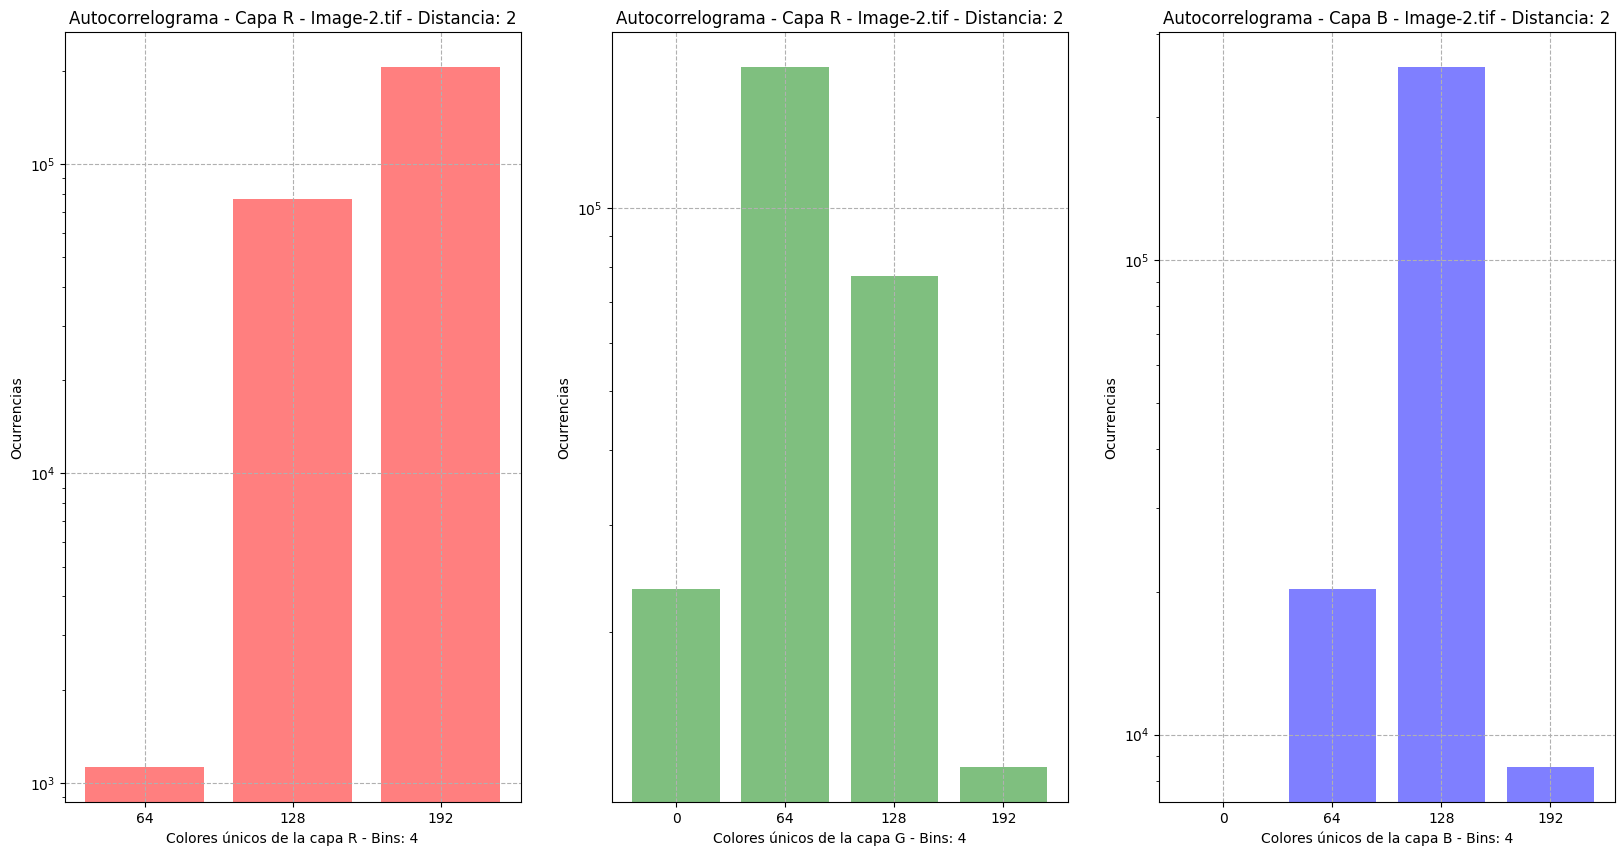

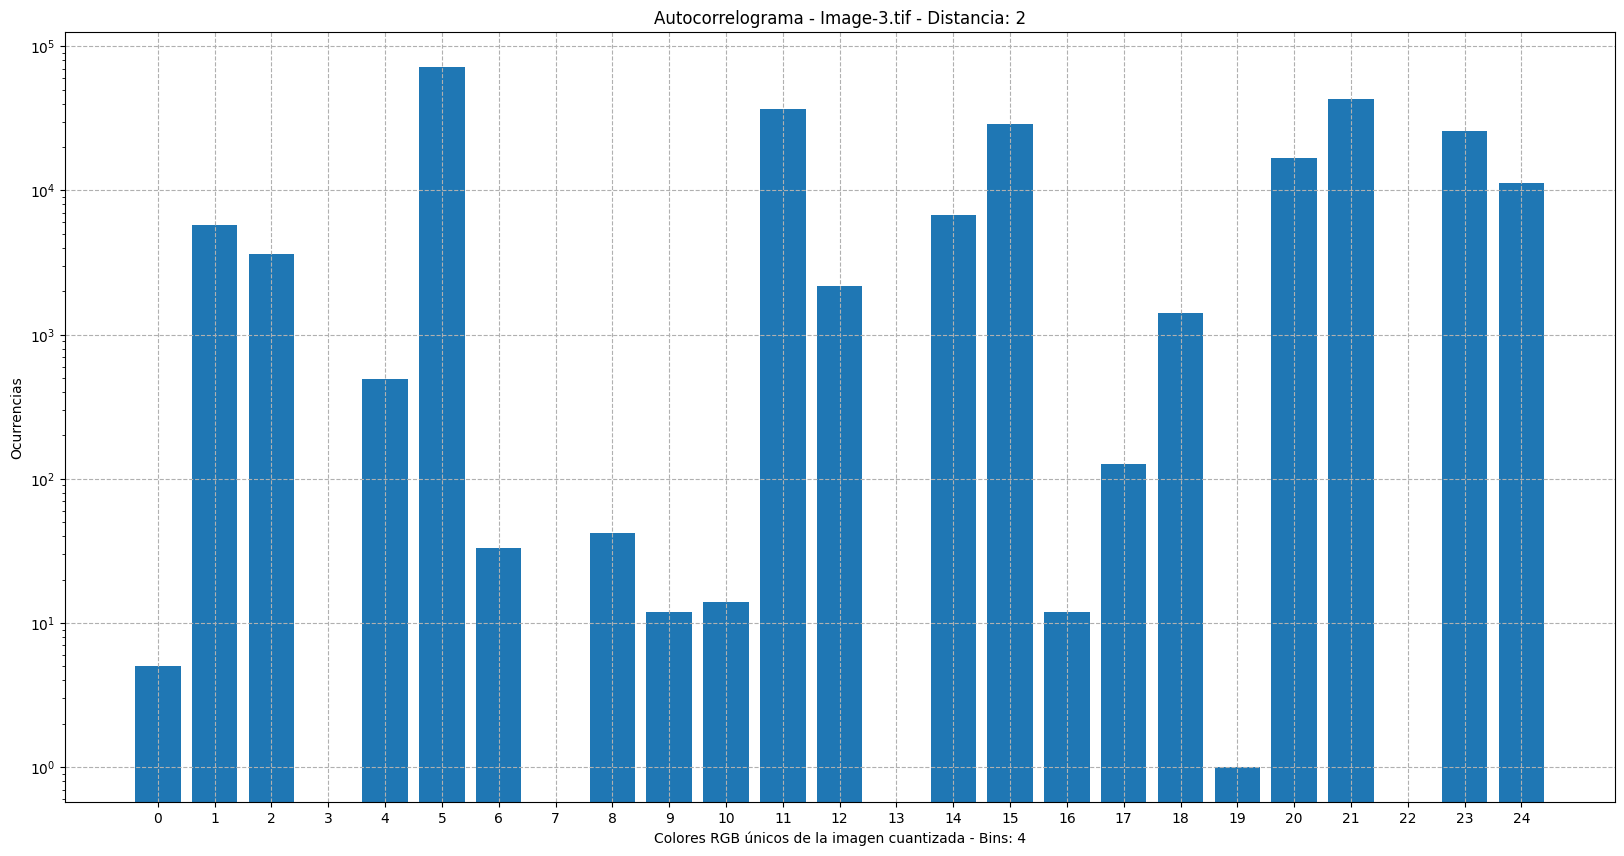

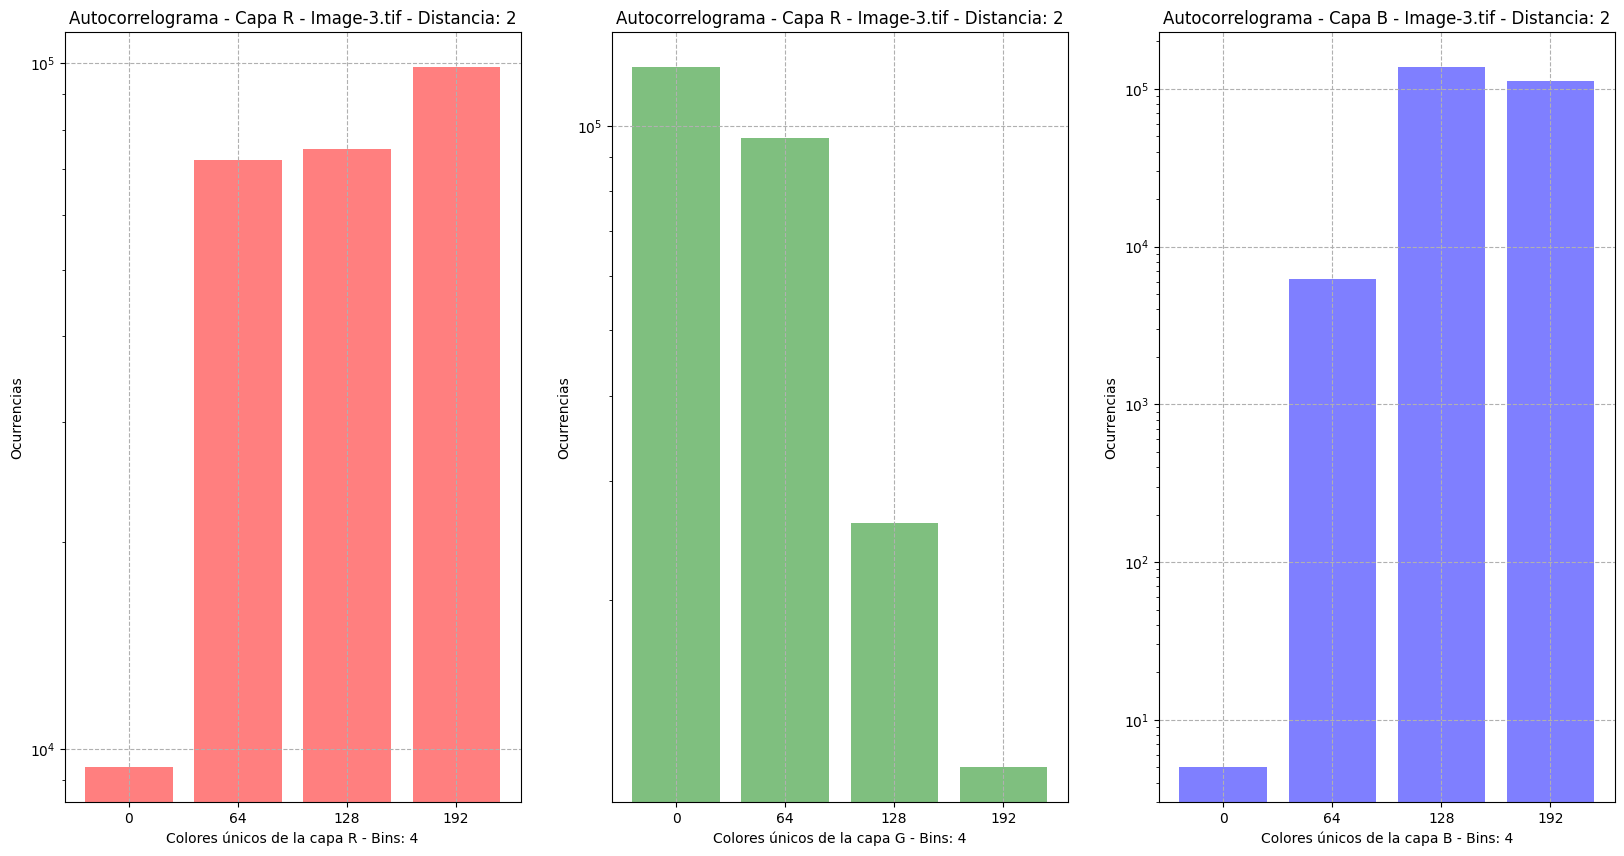

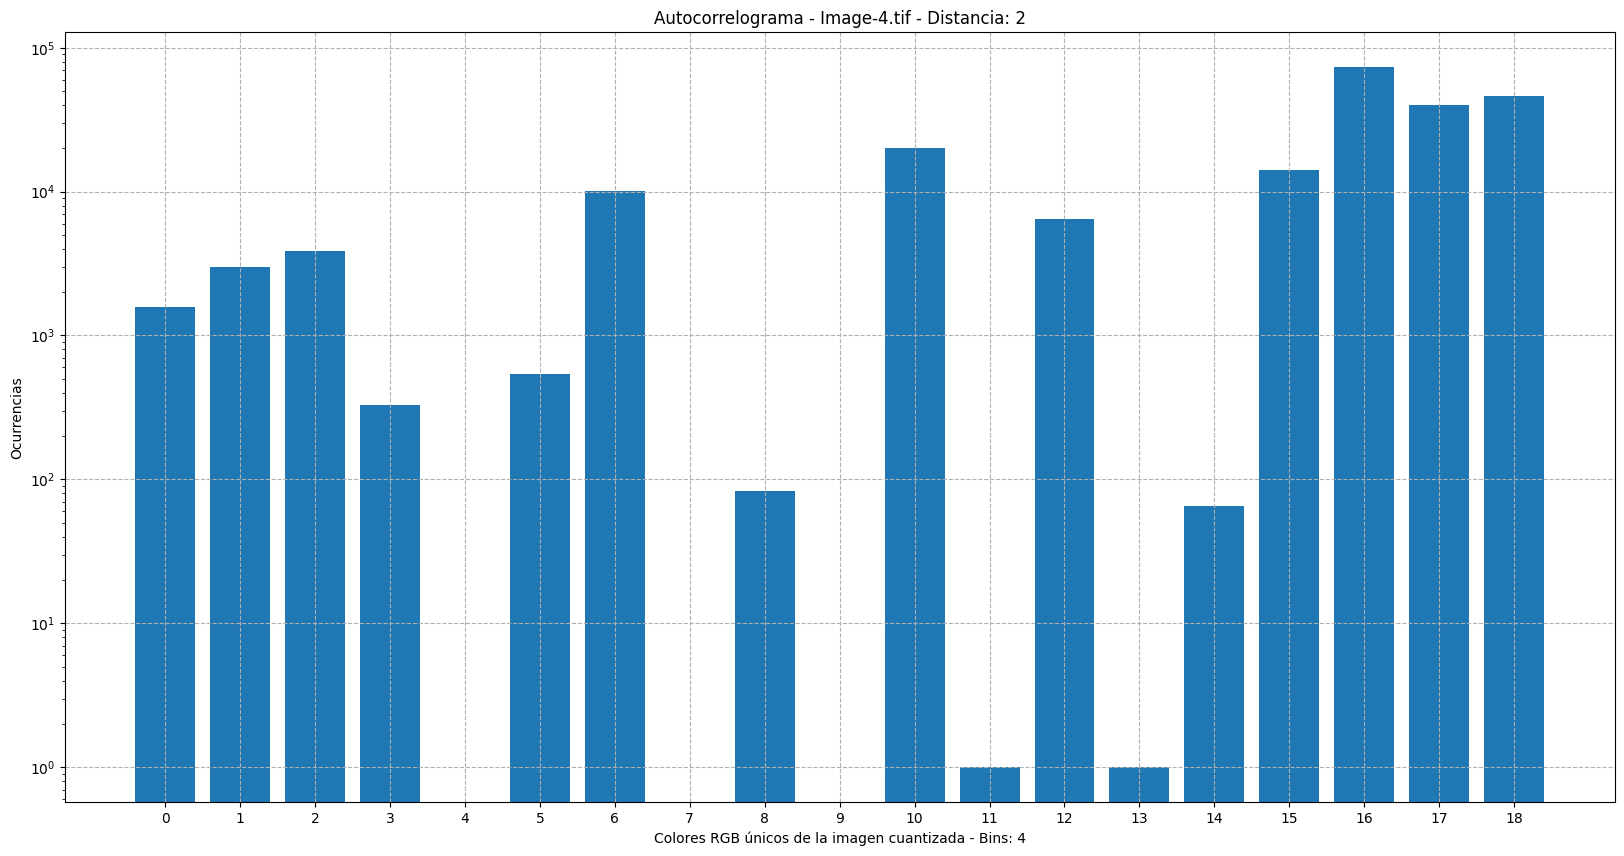

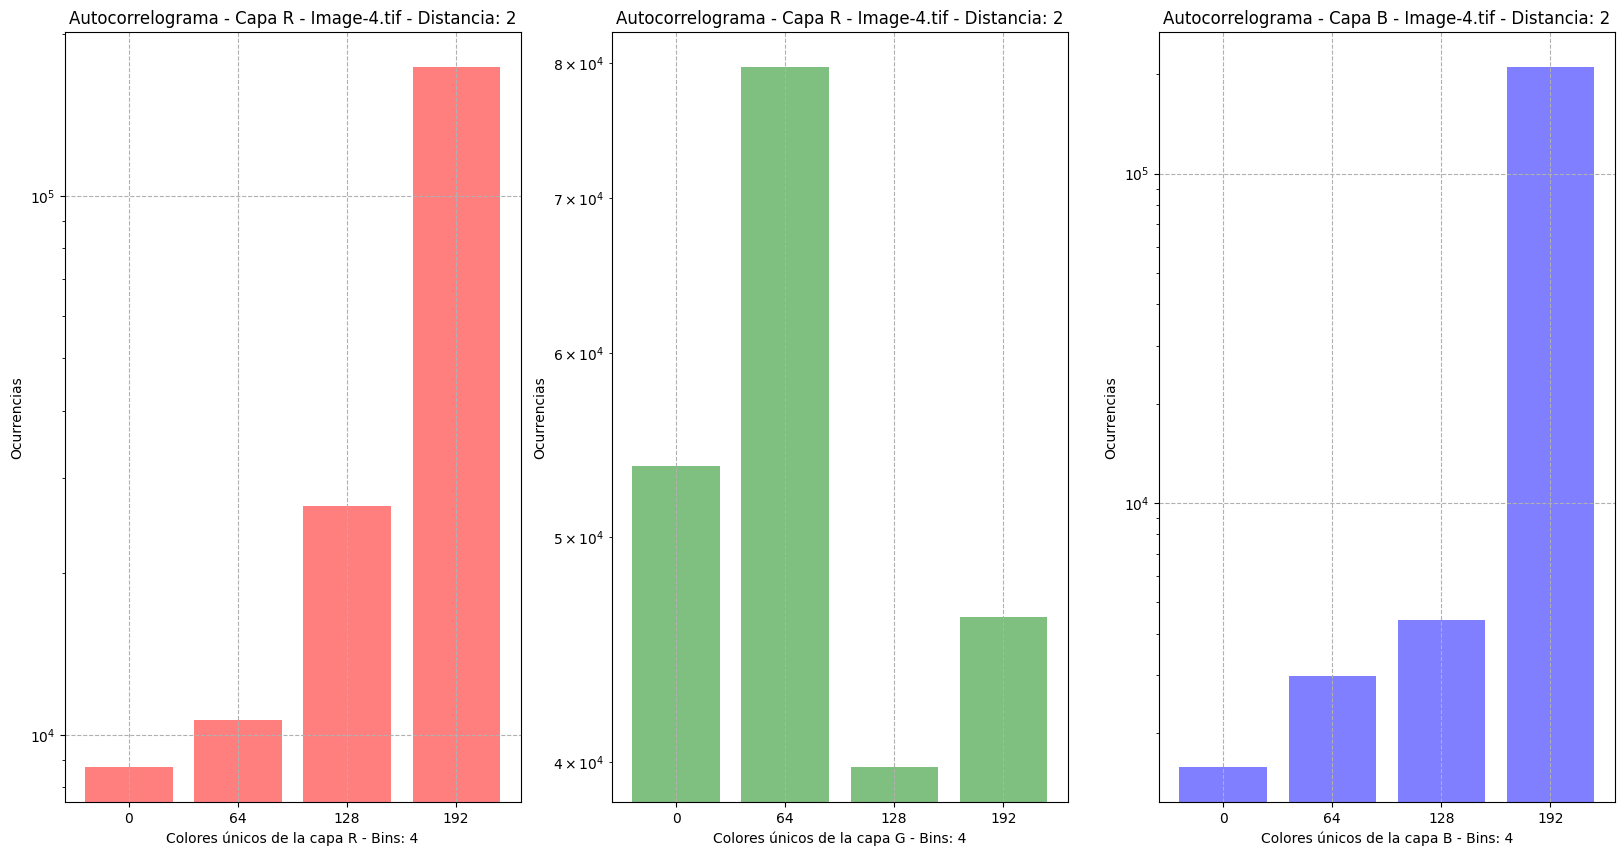

In [18]:
for colors, ocurrencies, i in zip(imgs_unique_colors,imgs_ocurrencies,range(len([*dict_folder.keys()]))):
    autocorrelogramPlots(colors,ocurrencies,dist=dist,bins=bins,img_name=[*dict_folder.keys()][i]).autocorrelogramComplete()
    autocorrelogramPlots(colors,ocurrencies,dist=dist,bins=bins,img_name=[*dict_folder.keys()][i]).autocorrelogramEachLayer()


In [19]:
if not os.path.exists('unique_colors'):
    os.makedirs('unique_colors')

if not os.path.exists('ocurrencies'):
    os.makedirs('ocurrencies')

ruta_archivo = 'unique_colors/uc_imgs'+'.pkl'
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(imgs_unique_colors, archivo)

ruta_archivo = 'ocurrencies/oc_imgs'+'.pkl'
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(imgs_ocurrencies, archivo)

print("Objetos guardados con éxito.")

Objetos guardados con éxito.


In [20]:
# Especificar la ruta del archivo
ruta_archivo = 'unique_colors/uc_imgs'+'.pkl'

# Cargar el objeto desde el archivo
with open(ruta_archivo, 'rb') as archivo:
    imgs_unique_colors_recovered = pickle.load(archivo)

# Especificar la ruta del archivo
ruta_archivo = 'ocurrencies/oc_imgs'+'.pkl'

# Cargar el objeto desde el archivo
with open(ruta_archivo, 'rb') as archivo:
    imgs_ocurrencies_recovered = pickle.load(archivo)


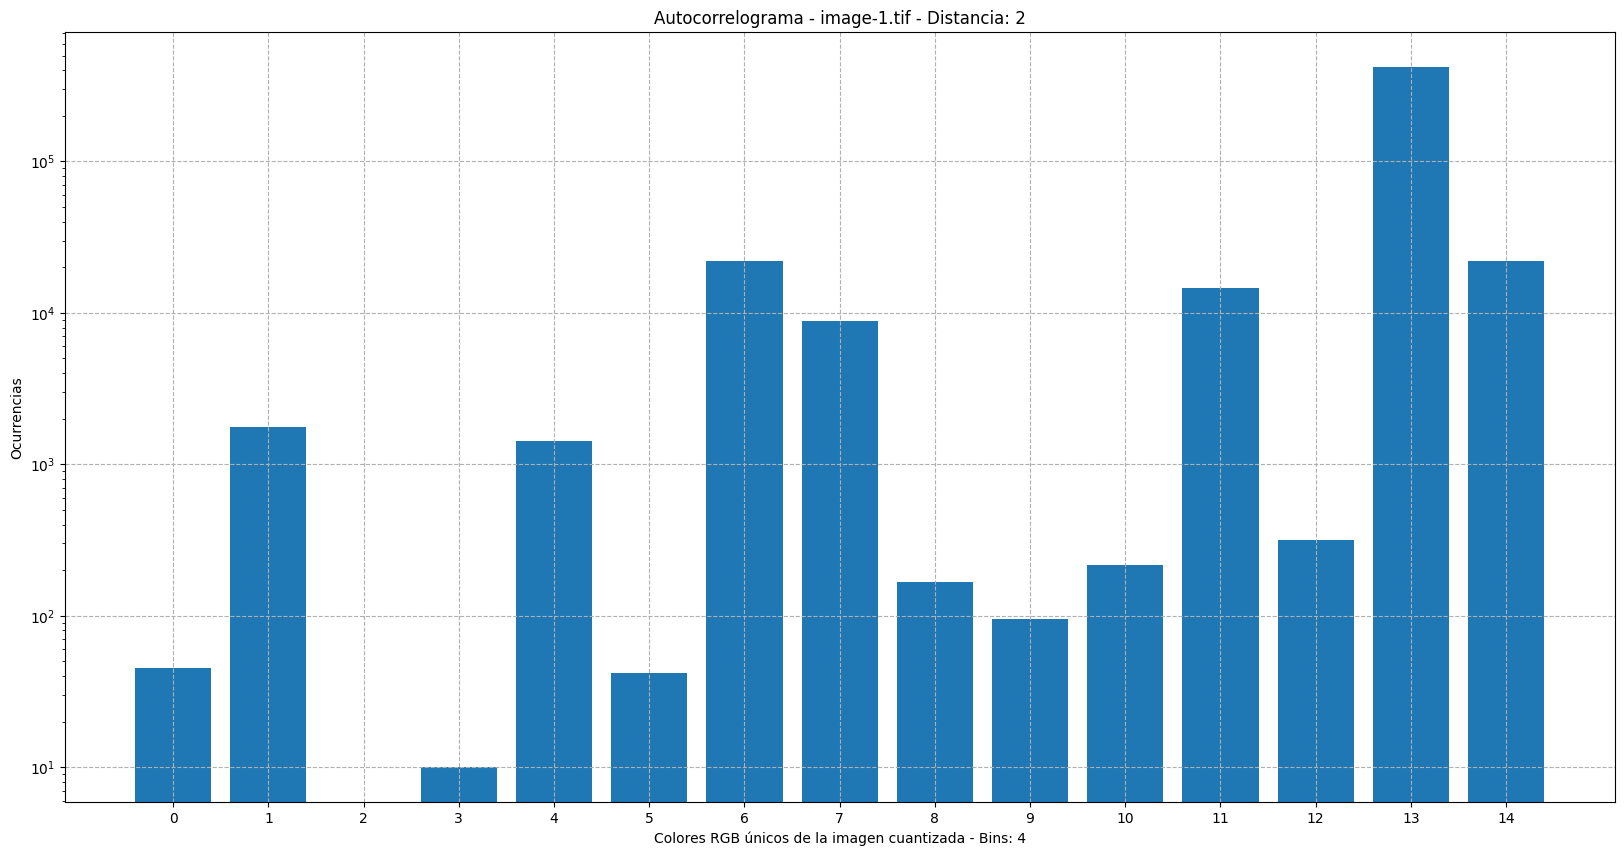

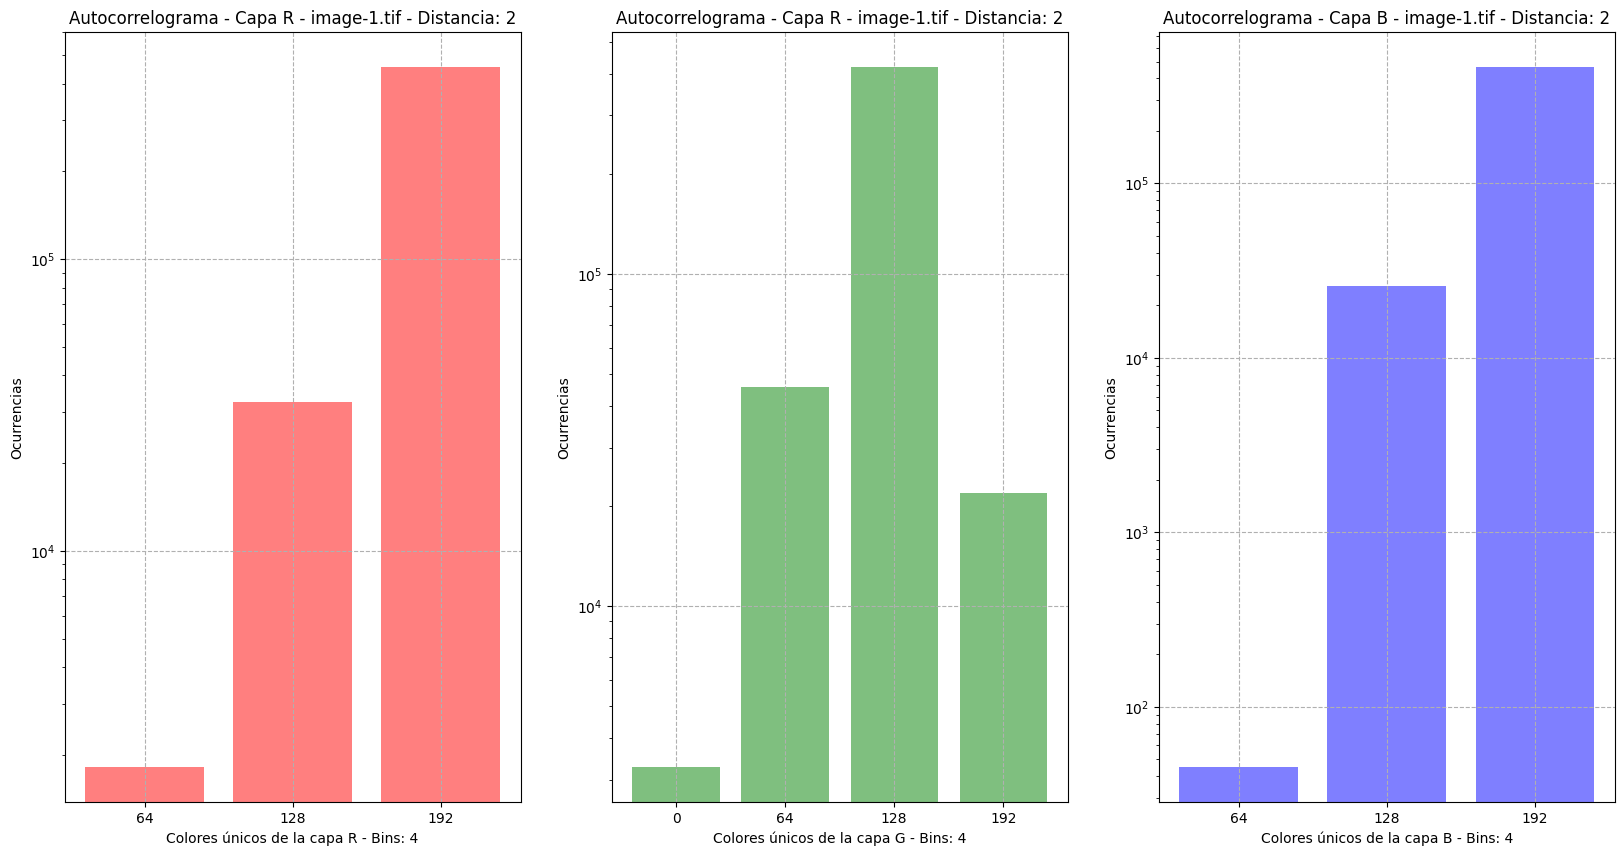

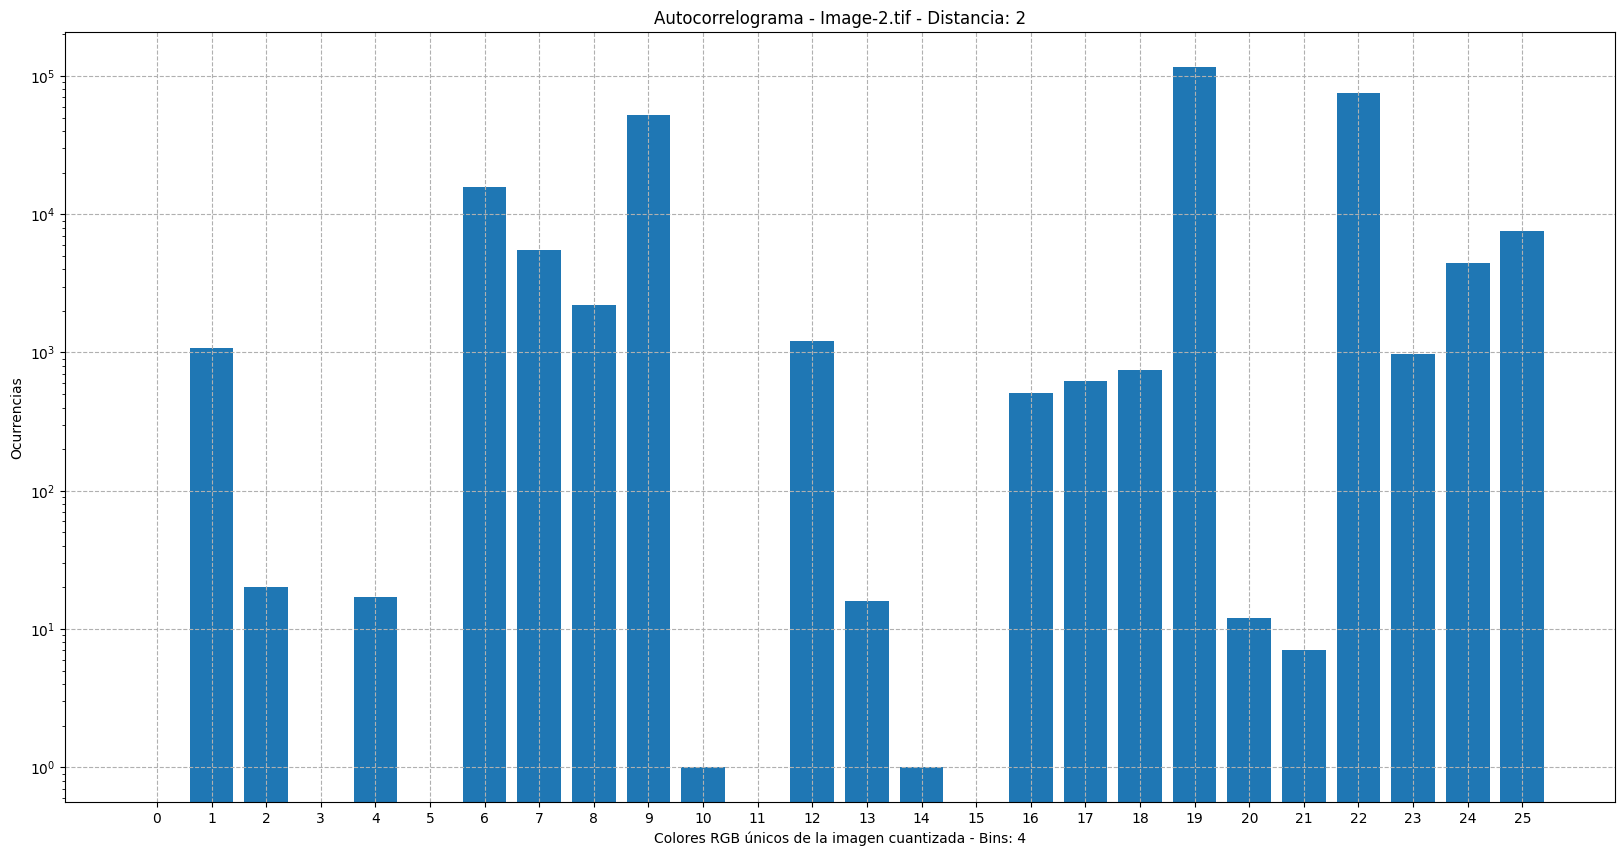

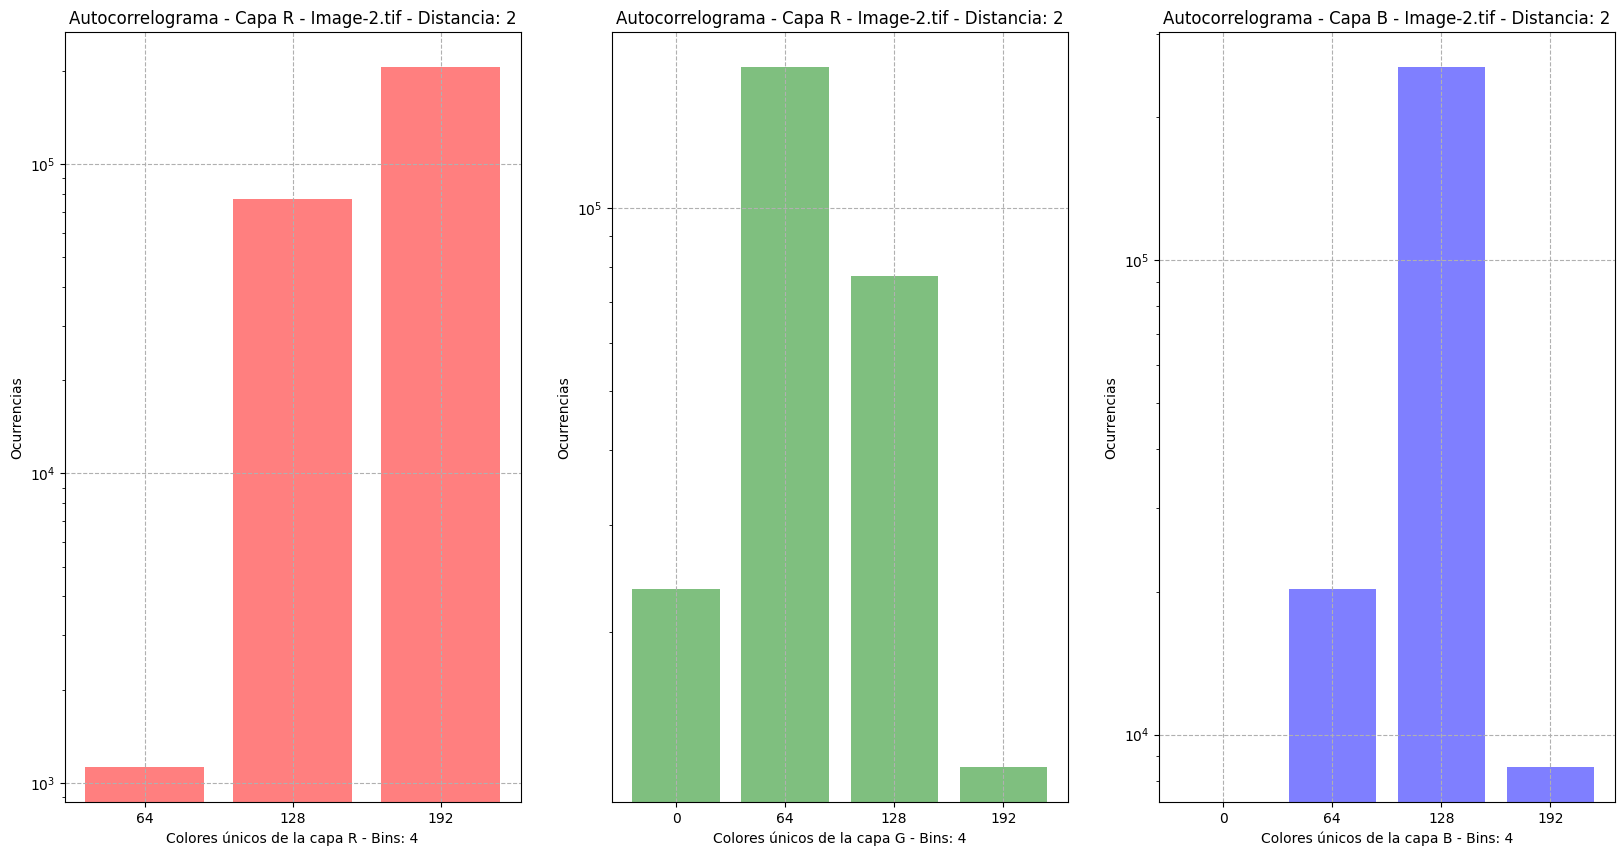

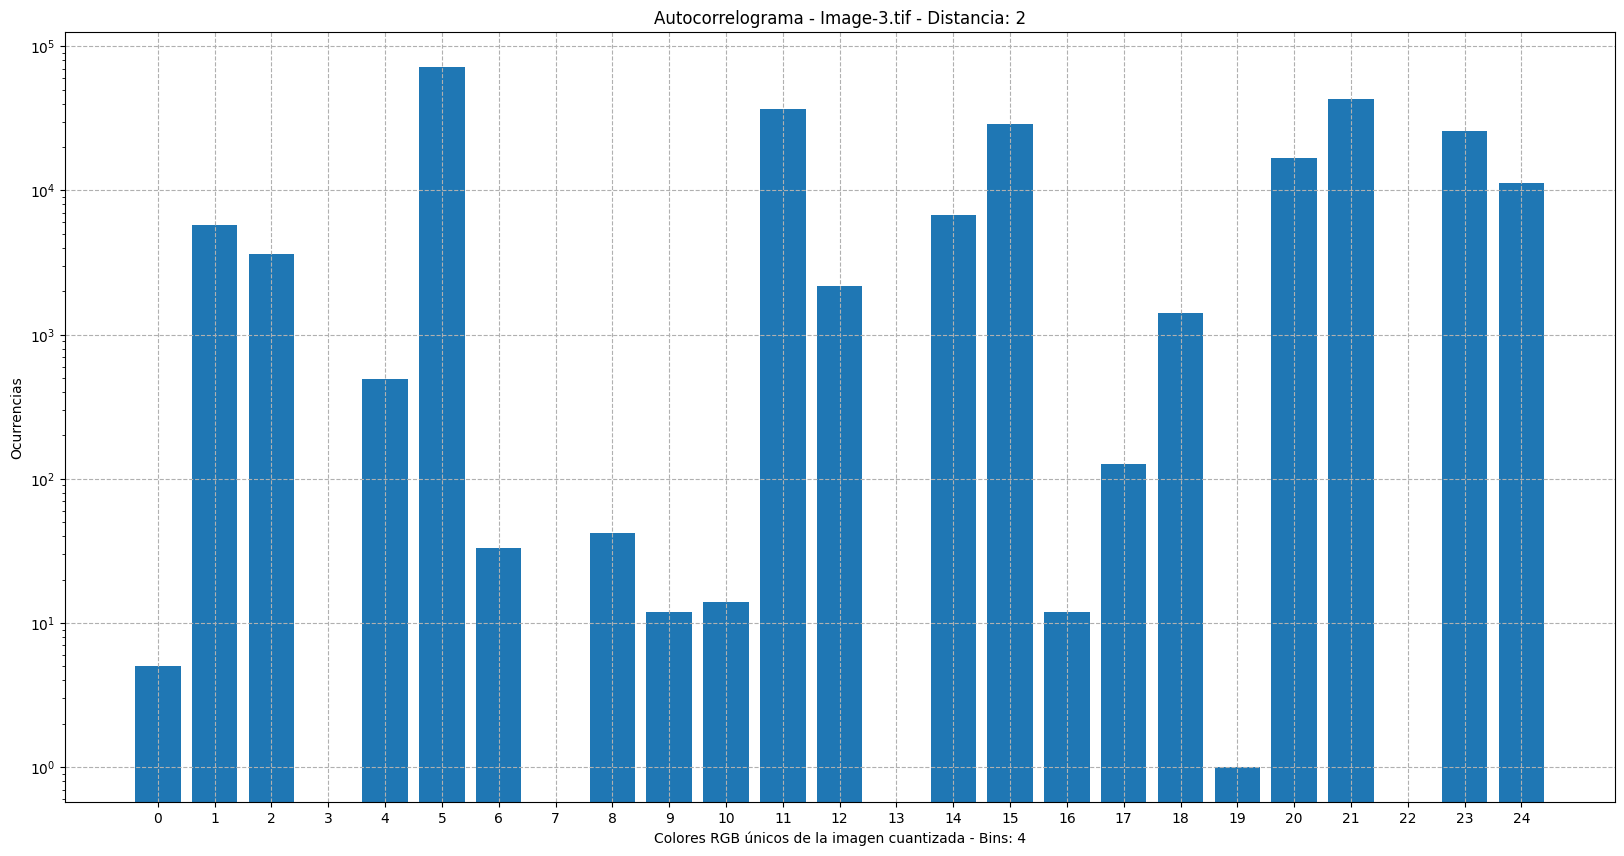

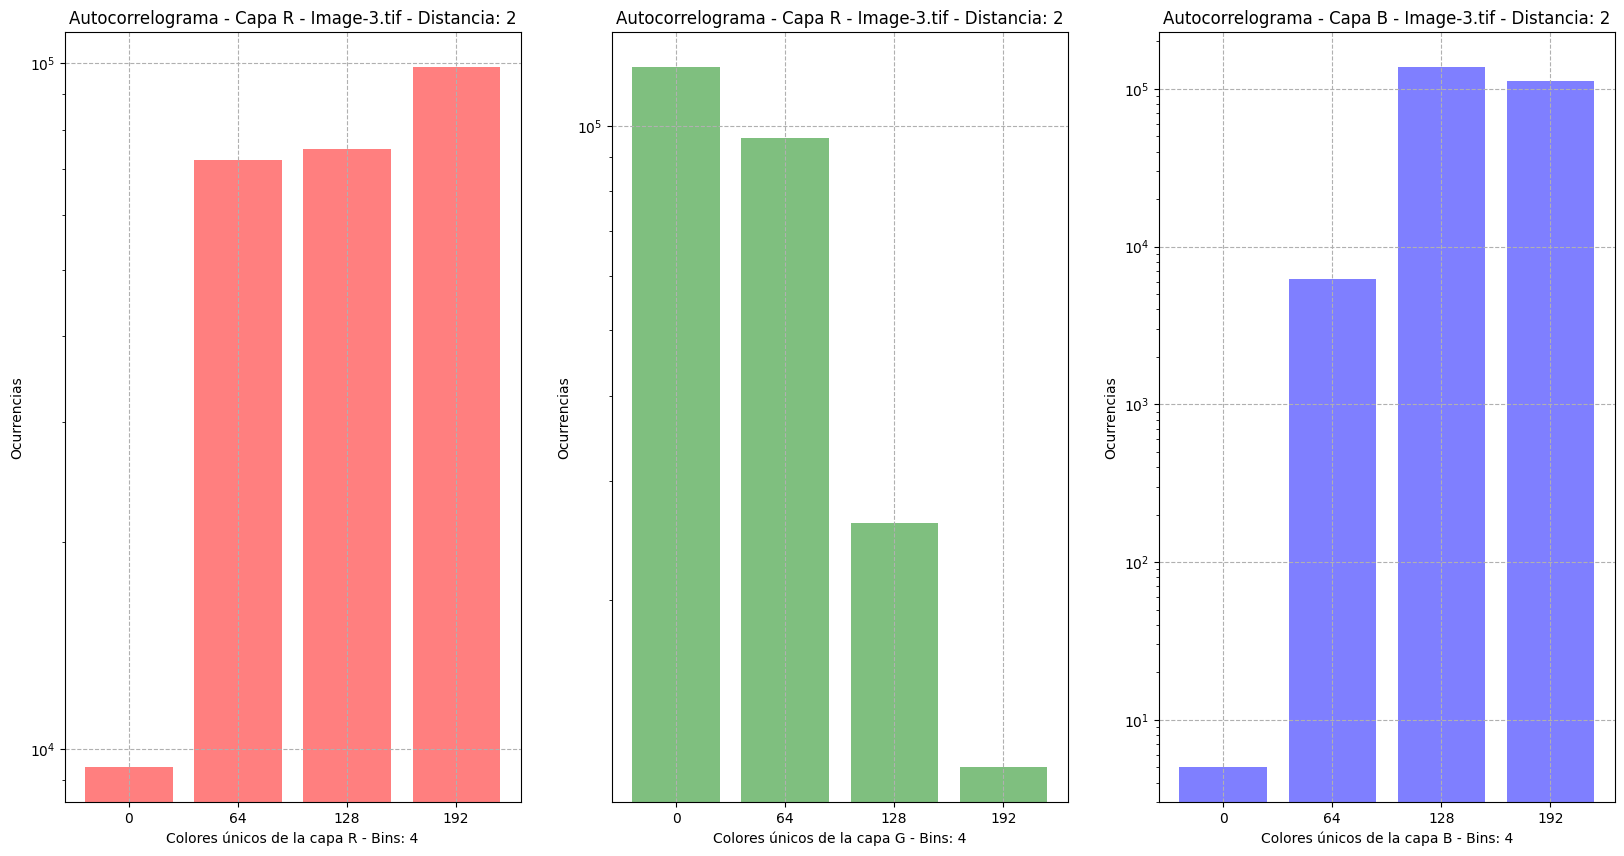

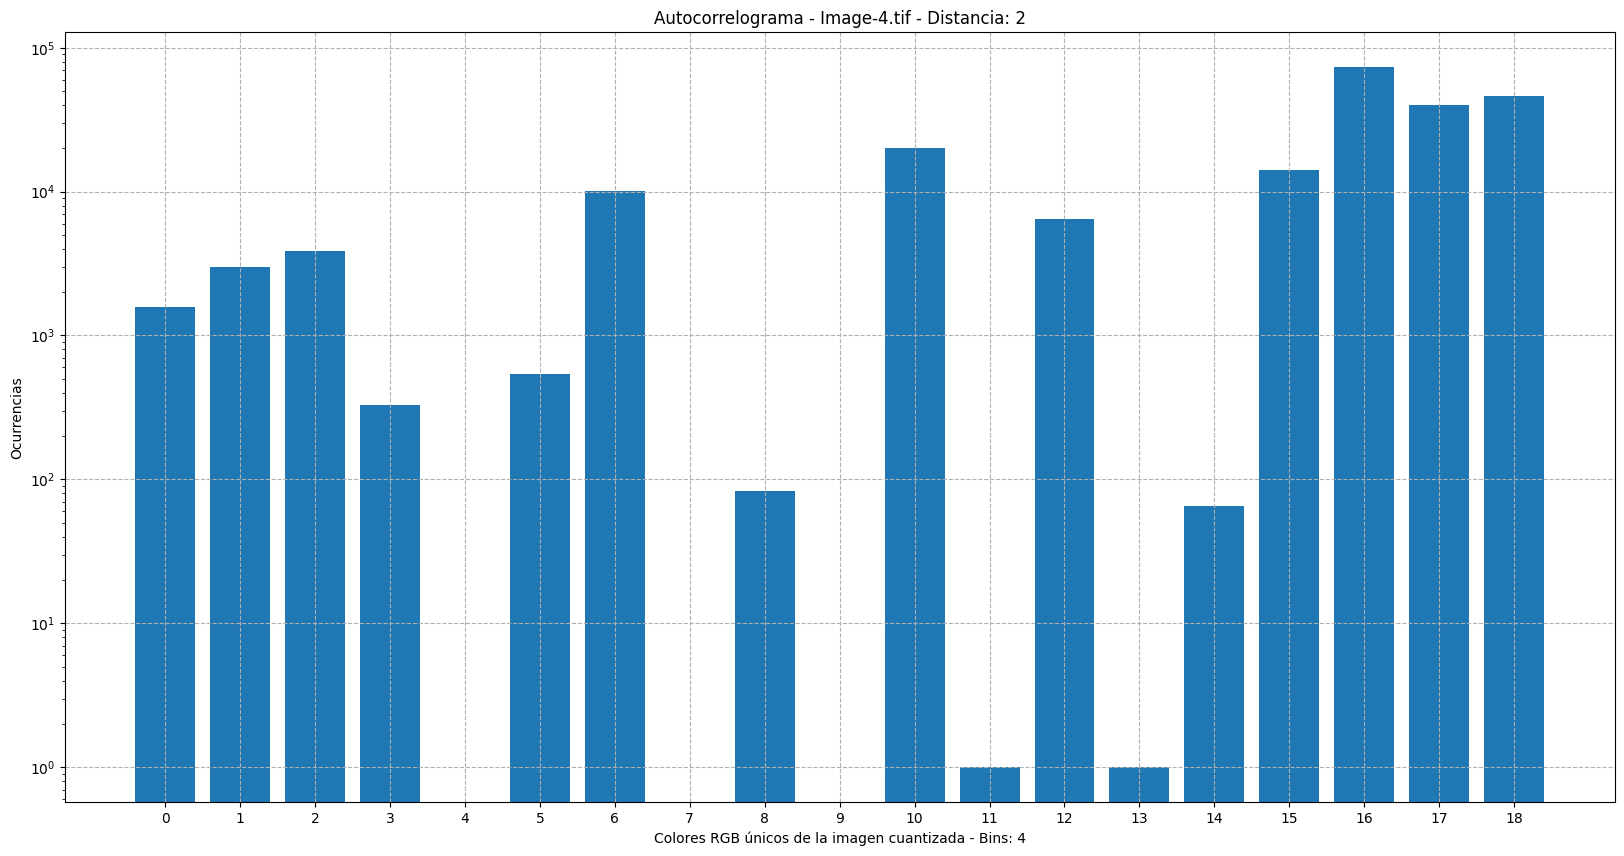

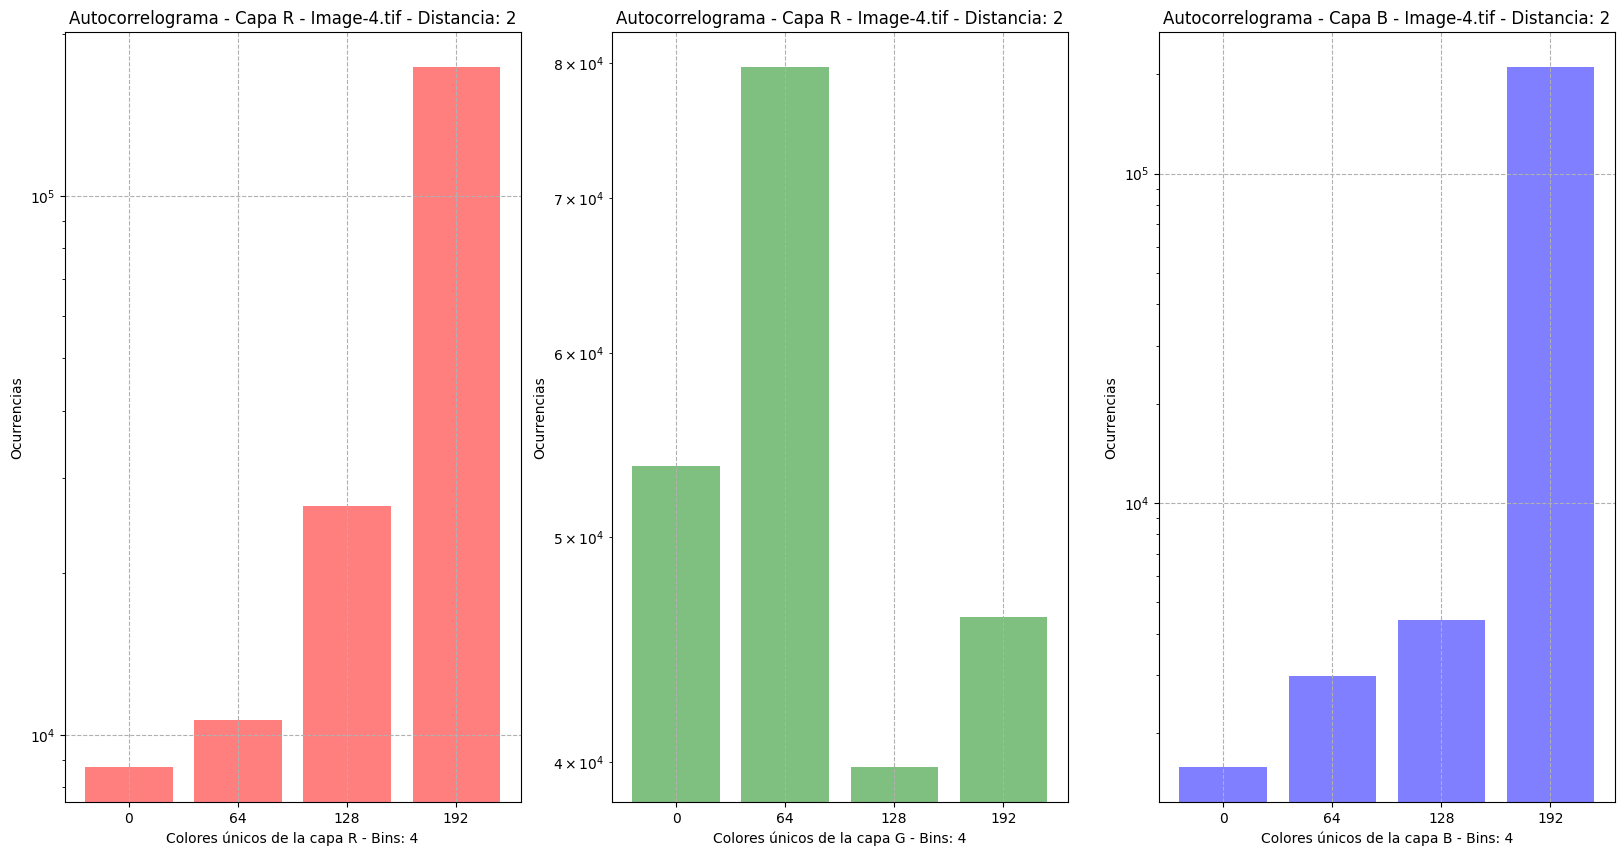

In [21]:
for colors, ocurrencies, i in zip(imgs_unique_colors_recovered,imgs_ocurrencies_recovered,range(len([*dict_folder.keys()]))):
    autocorrelogramPlots(colors,ocurrencies,dist=dist,bins=bins,img_name=[*dict_folder.keys()][i]).autocorrelogramComplete()
    autocorrelogramPlots(colors,ocurrencies,dist=dist,bins=bins,img_name=[*dict_folder.keys()][i]).autocorrelogramEachLayer()